In [1]:
# ================================
# Skin Cancer CNN + Fairness Suite
# ================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_score
from sklearn.utils import check_random_state

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# -------------------
# Config
# -------------------
CSV_PATH  = "/home/ec2-user/imbalanced_dataset.csv"
IMG_DIR   = "/home/ec2-user/imbalanced_dataset"
IMG_SIZE  = (224, 224)
BATCH     = 32
EPOCHS    = 200
LR        = 1e-5
SEED      = 42
VAL_SPLIT = 0.30
USE_VGG16 = True  # set True to use VGG16 backbone with AlexNet-style head

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------------------
# Load dataframe
# -------------------
fair_df = pd.read_csv(CSV_PATH)
# Labels: 0=Benign, 1=Malignant
fair_df["label"] = fair_df["diagnosis_1"].map({"Benign": 0, "Malignant": 1}).astype(int)
fair_df["filename"] = fair_df["isic_id"].astype(str) + ".jpg"

# sanity checks
for col in ["filename", "label", "FST_Skintone"]:
    if col not in fair_df.columns:
        raise ValueError(f"CSV must contain column: {col}")

# -------------------
# Add a stable "Control" grouping (for Control DI)
# -------------------
rng = check_random_state(SEED)
# deterministic 0/1 assignment based on filename hash
fair_df["ControlGroup"] = fair_df["filename"].apply(lambda s: (hash(s) & 1))
fair_df["ControlGroup"] = fair_df["ControlGroup"].map({0: "A", 1: "B"})

# -------------------
# Generators (no augmentation; rescale only)
# -------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)

train_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="training",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",   # returns integer labels
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="validation",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",
    shuffle=False,
    seed=SEED
)

# -------------------
# Models
# -------------------
def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (7,7), activation='relu', padding='same', input_shape=(*IMG_SIZE,3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16_alexnet_head():
    from tensorflow.keras.applications import VGG16
    inp = Input(shape=(*IMG_SIZE,3))
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inp)
    # freeze a few early layers (optional)
    for layer in base.layers[:3]:
        layer.trainable = False
    x = Flatten(name="flatten")(base.output)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='drop1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='drop2')(x)
    x = BatchNormalization(name='bn')(x)
    out = Dense(2, activation='softmax', name='pred')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_vgg16_alexnet_head() if USE_VGG16 else build_simple_cnn()
model.summary()

# -------------------
# Fairness Callback
# -------------------
class FairnessCallback(Callback):
    """
    Logs per-epoch:
      - Tone Disparate Impact (selection rate Dark/Light)
      - Control DI (selection rate GroupA/GroupB)
      - Group Sensitivity & Specificity
      - Predictive Quality Disparity (|PPV_L - PPV_D|)
    """
    def __init__(self, val_gen, meta_df):
        super().__init__()
        self.val_gen = val_gen
        self.meta = meta_df[["filename","FST_Skintone","ControlGroup"]].copy()
        self.hist = {k: [] for k in [
            "tdi","cdi","sens_light","sens_dark","spec_light","spec_dark","pqd"
        ]}
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()
        probs = self.model.predict(self.val_gen, verbose=0)   # (N,2)
        y_pred = probs.argmax(axis=1)
        y_true = self.val_gen.labels.astype(int)              # DataFrameIterator -> .labels

        # Merge preds with meta (align by filenames order)
        fnames = [os.path.basename(p) for p in self.val_gen.filenames]
        res = pd.DataFrame({"filename": fnames, "y_true": y_true, "y_pred": y_pred})
        merged = res.merge(self.meta, on="filename", how="left")

        # Selection rates
        def sel_rate(df): 
            return (df["y_pred"]==1).mean() if len(df) else np.nan
        dark  = merged[merged["FST_Skintone"]=="Dark"]
        light = merged[merged["FST_Skintone"]=="Light"]
        rate_dark, rate_light = sel_rate(dark), sel_rate(light)
        tdi = (rate_dark / rate_light) if (rate_light and not np.isnan(rate_light)) else np.nan

        grpA = merged[merged["ControlGroup"]=="A"]
        grpB = merged[merged["ControlGroup"]=="B"]
        rate_A, rate_B = sel_rate(grpA), sel_rate(grpB)
        cdi = (rate_A / rate_B) if (rate_B and not np.isnan(rate_B)) else np.nan

        # Sensitivity / Specificity by tone
        def sens_spec(df):
            if len(df)==0 or len(np.unique(df["y_true"]))<2:
                return np.nan, np.nan
            cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
            TN, FP, FN, TP = cm.ravel()
            sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
            spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
            return sens, spec

        sens_L, spec_L = sens_spec(light)
        sens_D, spec_D = sens_spec(dark)

        # Predictive Quality Disparity (difference in precision)
        def prec(df):
            if len(df)==0 or (df["y_pred"]==1).sum()==0:
                return 0.0
            return precision_score(df["y_true"], df["y_pred"], zero_division=0)
        pqd = abs(prec(light) - prec(dark))

        # store
        self.epochs.append(epoch+1)
        self.hist["tdi"].append(tdi)
        self.hist["cdi"].append(cdi)
        self.hist["sens_light"].append(sens_L)
        self.hist["sens_dark"].append(sens_D)
        self.hist["spec_light"].append(spec_L)
        self.hist["spec_dark"].append(spec_D)
        self.hist["pqd"].append(pqd)

        print(f"\n[Fairness @ epoch {epoch+1}] TDI={tdi:.3f}  CDI={cdi:.3f}  PQD={pqd:.3f} | "
              f"Light Sens={sens_L:.3f} Spec={spec_L:.3f} | Dark Sens={sens_D:.3f} Spec={spec_D:.3f}")

# meta for callback
meta_for_val = fair_df[["filename","FST_Skintone","ControlGroup"]].copy()
fair_cb = FairnessCallback(val_gen, meta_for_val)

# -------------------
# Training
# -------------------
early = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
ckpt  = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early, ckpt, fair_cb],
    verbose=1
)

# -------------------
# Final Evaluation
# -------------------
val_gen.reset()
probs = model.predict(val_gen, verbose=0)       # (N,2)
y_prob = probs[:,1]                              # P(malignant)
y_pred = probs.argmax(axis=1)
y_true = val_gen.labels.astype(int)

print("\nConfusion Matrix (overall):\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report (overall):\n", classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

# Build merged_df for group analyses & plots
results_df = pd.DataFrame({
    "filename": [os.path.basename(f) for f in val_gen.filenames],
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_prob
})
merged_df = results_df.merge(fair_df[["filename","FST_Skintone","ControlGroup"]], on="filename", how="left")

# TDI (final)
dark  = merged_df[merged_df["FST_Skintone"]=="Dark"]
light = merged_df[merged_df["FST_Skintone"]=="Light"]
rate_dark  = (dark["y_pred"]==1).mean()
rate_light = (light["y_pred"]==1).mean()
TDI = (rate_dark / rate_light) if rate_light>0 else np.nan
print(f"\nFINAL Tone Disparate Impact = {TDI:.3f}")

# PQD (final)
prec_L = precision_score(light["y_true"], light["y_pred"], zero_division=0) if len(light) else np.nan
prec_D = precision_score(dark["y_true"],  dark["y_pred"],  zero_division=0) if len(dark)  else np.nan
PQD = abs(prec_L - prec_D)
print(f"FINAL Predictive Quality Disparity (|PPV_L - PPV_D|) = {PQD:.3f}")

# Sens/Spec by group (final)
def sens_spec(df):
    if len(df)==0 or len(np.unique(df["y_true"]))<2:
        return np.nan, np.nan, None
    cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
    spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
    return sens, spec, cm

sens_L, spec_L, cm_L = sens_spec(light)
sens_D, spec_D, cm_D = sens_spec(dark)
print(f"\nLight  Sens={sens_L:.3f}  Spec={spec_L:.3f}  Confusion=\n{cm_L}")
print(f"Dark   Sens={sens_D:.3f}  Spec={spec_D:.3f}  Confusion=\n{cm_D}")



2025-08-23 09:47:36.036044: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-23 09:47:36.615976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755942456.826654    3051 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755942456.889190    3051 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-23 09:47:37.428391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 7085 validated image filenames.
Found 3036 validated image filenames.


I0000 00:00:1755942462.044699    3051 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn (BatchNormalization)         │ (None, 4096)           │        16,38

 Total params: 134,285,122 (512.26 MB)

 Trainable params: 134,238,210 (512.08 MB)

 Non-trainable params: 46,912 (183.25 KB)

/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


I0000 00:00:1755942474.234723    3230 service.cc:148] XLA service 0x7efe4001e3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755942474.234758    3230 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-08-23 09:47:54.366931: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755942474.993089    3230 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-08-23 09:47:56.067392: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activa

110/222 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - accuracy: 0.5944 - loss: 0.8658

2025-08-23 09:51:53.581953: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[13,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-23 09:51:53.645018: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[13,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6422 - loss: 0.7897

2025-08-23 09:55:41.068646: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,112,112]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-23 09:55:41.986813: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,112,112]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$c


[Fairness @ epoch 1] TDI=0.494  CDI=1.055  PQD=0.203 | Light Sens=0.877 Spec=0.843 | Dark Sens=0.894 Spec=0.898
222/222 ━━━━━━━━━━━━━━━━━━━━ 849s 4s/step - accuracy: 0.6426 - loss: 0.7891 - val_accuracy: 0.8702 - val_loss: 0.6791
Epoch 2/200
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8577 - loss: 0.4349
[Fairness @ epoch 2] TDI=0.395  CDI=1.000  PQD=0.030 | Light Sens=0.634 Spec=0.971 | Dark Sens=0.761 Spec=0.994
222/222 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - accuracy: 0.8577 - loss: 0.4348 - val_accuracy: 0.9147 - val_loss: 0.3151
Epoch 3/200
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8951 - loss: 0.3455
[Fairness @ epoch 3] TDI=0.392  CDI=0.993  PQD=0.080 | Light Sens=0.781 Spec=0.946 | Dark Sens=0.814 Spec=0.974
222/222 ━━━━━━━━━━━━━━━━━━━━ 729s 3s/step - accuracy: 0.8951 - loss: 0.3454 - val_accuracy: 0.9233 - val_loss: 0.3348
Epoch 4/200
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9071 - loss: 0.2862
[Fairness @ epoch 4] TDI=0.383  CDI=1.052  PQD=0.06

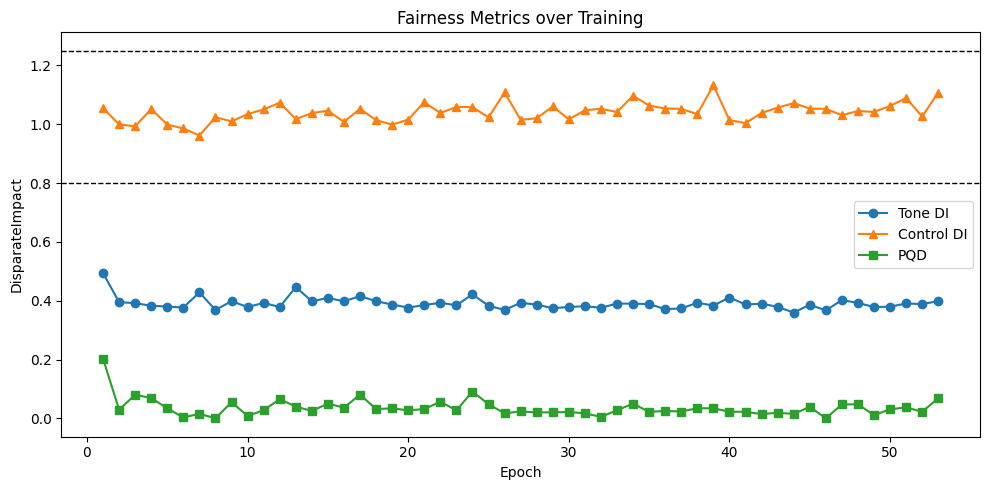

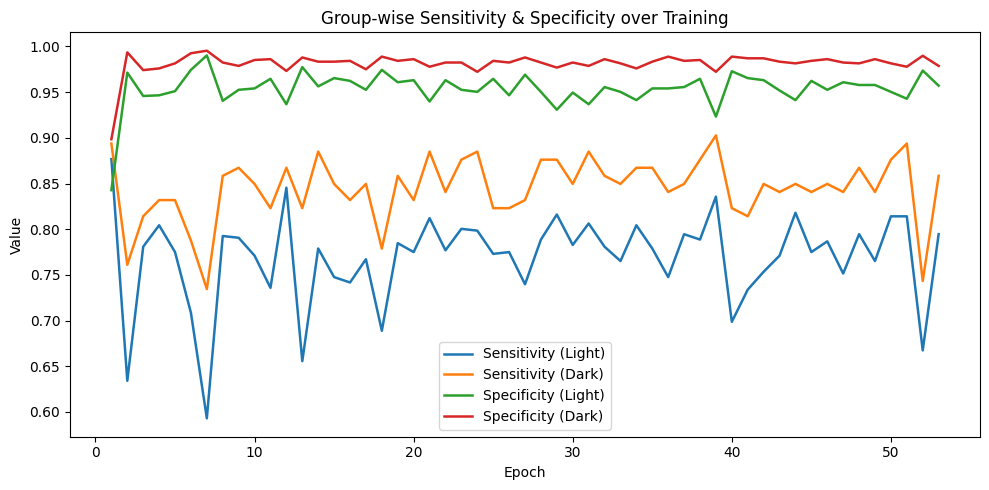

In [6]:
# -------------------
# Plot fairness over epochs
# -------------------
epochs = fair_cb.epochs
H = fair_cb.hist

# TDI, Control DI, PQD
plt.figure(figsize=(10,5))
plt.plot(epochs, H["tdi"], marker='o', lw=1.5, label="Tone DI")
plt.plot(epochs, H["cdi"], marker='^', lw=1.5, label="Control DI")
plt.plot(epochs, H["pqd"], marker='s', lw=1.5, label="PQD")
plt.axhline(0.8, color='k', linestyle='--', lw=1)
plt.axhline(1.25, color='k', linestyle='--', lw=1)
plt.xlabel("Epoch")
plt.ylabel("DisparateImpact")
plt.title("Fairness Metrics over Training")
plt.legend()
plt.tight_layout()
plt.show()

# Sensitivity/Specificity by group
plt.figure(figsize=(10,5))
plt.plot(epochs, H["sens_light"], lw=1.8, label="Sensitivity (Light)")
plt.plot(epochs, H["sens_dark"],  lw=1.8, label="Sensitivity (Dark)")
plt.plot(epochs, H["spec_light"], lw=1.8, label="Specificity (Light)")
plt.plot(epochs, H["spec_dark"],  lw=1.8, label="Specificity (Dark)")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Group-wise Sensitivity & Specificity over Training")
plt.legend()
plt.tight_layout()
plt.show()


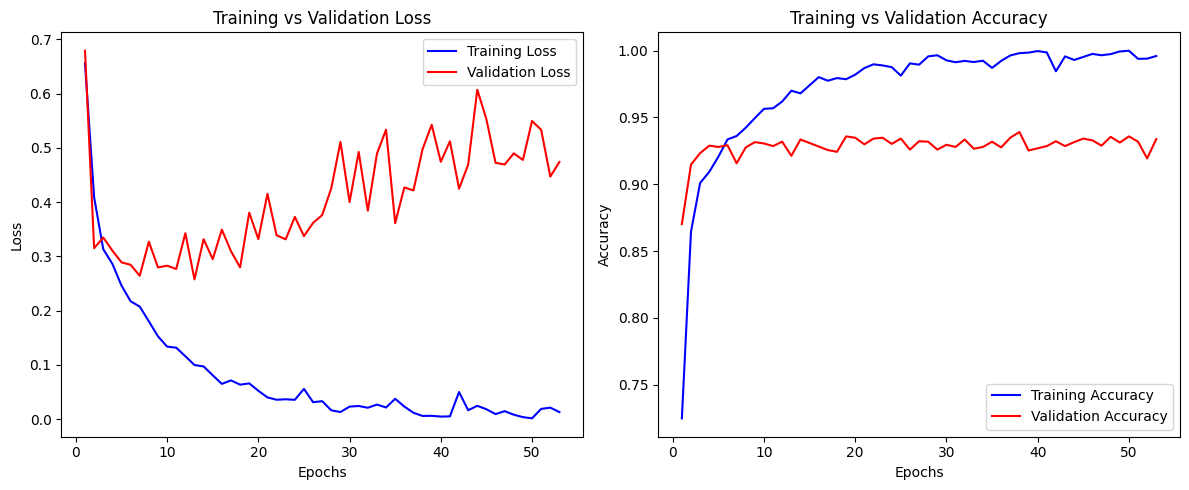

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Extract history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Find best epoch (lowest val_loss)
best_epoch = np.argmin(val_loss) + 1

plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
#plt.axvline(best_epoch, color='g', linestyle='--', label=f'Early Stopping @ {best_epoch}')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# --- Plot Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
#plt.axvline(best_epoch, color='g', linestyle='--', label=f'Early Stopping @ {best_epoch}')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("loss.png", dpi=300, bbox_inches="tight")
plt.show()


In [7]:
from sklearn.metrics import matthews_corrcoef, roc_curve, auc

for group in ["Light","Dark"]:
    g = merged_df[merged_df["FST_Skintone"] == group]
    if len(g) == 0 or len(np.unique(g["y_true"])) < 2:
        print(f"{group}: not enough data for ROC/MCC.")
        continue
    mcc_g = matthews_corrcoef(g["y_true"], g["y_pred"])
    fpr_g, tpr_g, _ = roc_curve(g["y_true"], g["y_score"])
    auc_g = auc(fpr_g, tpr_g)
    print(f"{group} → MCC: {mcc_g:.4f} | AUC: {auc_g:.4f}")


Light → MCC: 0.7109 | AUC: 0.9265
Dark → MCC: 0.8347 | AUC: 0.9744


Matthews Correlation Coefficient (overall): 0.7457

Confusion Matrix (labels: 0=Benign, 1=Malignant):
[[2369   43]
 [ 196  428]]

TN=2369  FP=43  FN=196  TP=428

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.98      0.95      2412
   Malignant       0.91      0.69      0.78       624

    accuracy                           0.92      3036
   macro avg       0.92      0.83      0.87      3036
weighted avg       0.92      0.92      0.92      3036



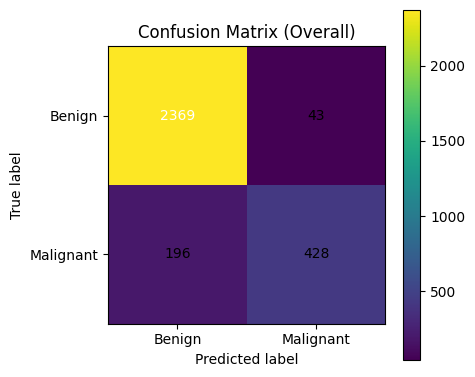

NameError: name 'fpr' is not defined

In [15]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_curve, auc, classification_report
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) Matthews Correlation Coefficient (overall) ----
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient (overall): {mcc:.4f}")

# ---- 2) Confusion Matrix (overall) ----
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix (labels: 0=Benign, 1=Malignant):")
print(cm)
print(f"\nTN={tn}  FP={fp}  FN={fn}  TP={tp}")

# Optional: classification report for completeness
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

# Optional: visualize confusion matrix
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Overall)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Benign","Malignant"])
plt.yticks(tick_marks, ["Benign","Malignant"])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# annotate counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# ---- 3) ROC Curve (overall) ----
# y_score should be the probability for class 1 (Malignant)
fpr, tpr, _ = roc_curve(y_true, y_score
roc_auc = auc(fpr, tpr)
print(f"\nROC-AUC (overall): {roc_auc:.4f}")

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle='--', lw=1, label='Random')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve (Overall)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



ROC-AUC (Light) = 0.927 | ROC-AUC (Dark) = 0.974


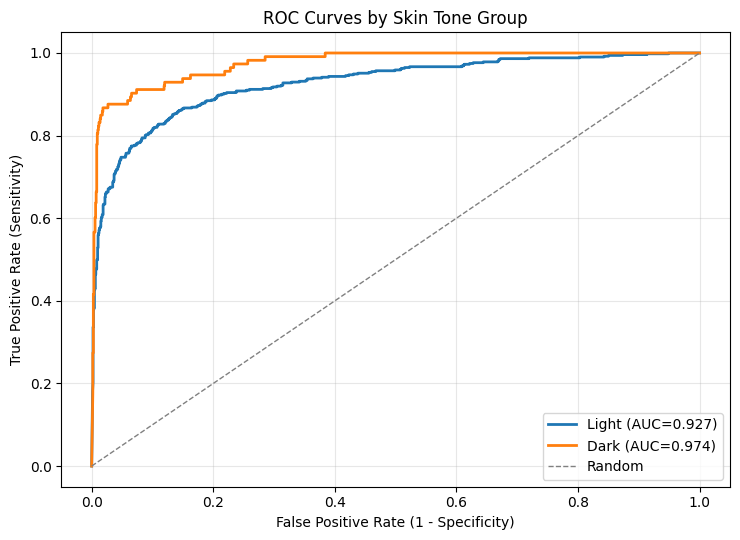

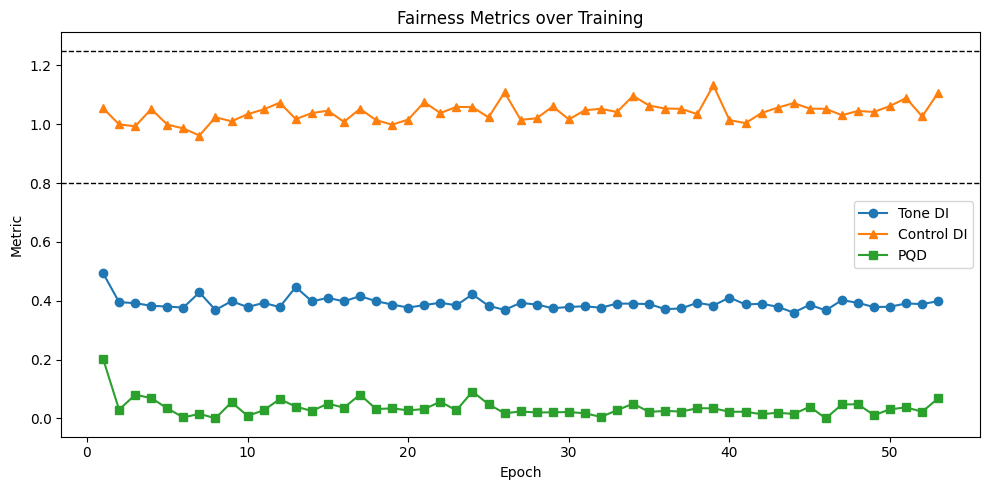

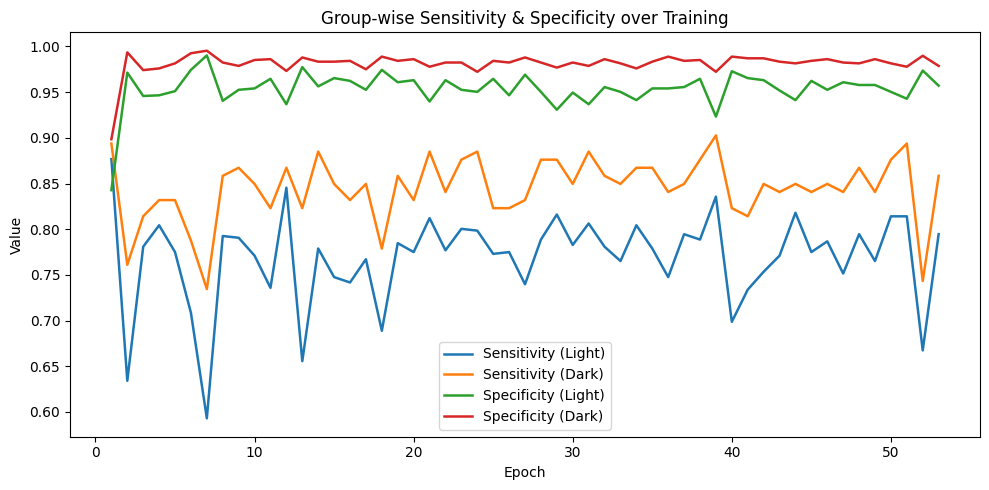

In [17]:
# ROC-AUC by group + ROC curves
def group_roc(df, name):
    if len(df)==0 or len(np.unique(df["y_true"]))<2:
        print(f"{name}: not enough positives/negatives for ROC.")
        return None, None, None, np.nan
    fpr, tpr, _ = roc_curve(df["y_true"], df["y_score"])
    group_auc = auc(fpr, tpr)
    return fpr, tpr, _, group_auc

fpr_L, tpr_L, _, auc_L = group_roc(light, "Light")
fpr_D, tpr_D, _, auc_D = group_roc(dark,  "Dark")
print(f"\nROC-AUC (Light) = {auc_L:.3f} | ROC-AUC (Dark) = {auc_D:.3f}")

# Plot ROC curves
plt.figure(figsize=(7.5,5.5))
if fpr_L is not None:
    plt.plot(fpr_L, tpr_L, lw=2, label=f"Light (AUC={auc_L:.3f})")
if fpr_D is not None:
    plt.plot(fpr_D, tpr_D, lw=2, label=f"Dark (AUC={auc_D:.3f})")
plt.plot([0,1],[0,1],'--', lw=1, color='gray', label='Random')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curves by Skin Tone Group")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------
# Plot fairness over epochs
# -------------------
epochs = fair_cb.epochs
H = fair_cb.hist

# TDI, Control DI, PQD
plt.figure(figsize=(10,5))
plt.plot(epochs, H["tdi"], marker='o', lw=1.5, label="Tone DI")
plt.plot(epochs, H["cdi"], marker='^', lw=1.5, label="Control DI")
plt.plot(epochs, H["pqd"], marker='s', lw=1.5, label="PQD")
plt.axhline(0.8, color='k', linestyle='--', lw=1)
plt.axhline(1.25, color='k', linestyle='--', lw=1)
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Fairness Metrics over Training")
plt.legend()
plt.tight_layout()
plt.savefig("fairness matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Sensitivity/Specificity by group
plt.figure(figsize=(10,5))
plt.plot(epochs, H["sens_light"], lw=1.8, label="Sensitivity (Light)")
plt.plot(epochs, H["sens_dark"],  lw=1.8, label="Sensitivity (Dark)")
plt.plot(epochs, H["spec_light"], lw=1.8, label="Specificity (Light)")
plt.plot(epochs, H["spec_dark"],  lw=1.8, label="Specificity (Dark)")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Group-wise Sensitivity & Specificity over Training")
plt.legend()
plt.tight_layout()

plt.show()


##Custom CNN - Balanced dataset

In [1]:
# ================================
# Skin Cancer CNN + Fairness Suite
# ================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_score
from sklearn.utils import check_random_state

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# -------------------
# Config
# -------------------
CSV_PATH  = "/home/ec2-user/balanced_dataset.csv"
IMG_DIR   = "/home/ec2-user/balanced_dataset/"
IMG_SIZE  = (224, 224)
BATCH     = 32
EPOCHS    = 200
LR        = 1e-5
SEED      = 42
VAL_SPLIT = 0.30
USE_VGG16 = False  # set True to use VGG16 backbone with AlexNet-style head

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------------------
# Load dataframe
# -------------------
fair_df = pd.read_csv(CSV_PATH)
# Labels: 0=Benign, 1=Malignant
fair_df["label"] = fair_df["diagnosis_1"].map({"Benign": 0, "Malignant": 1}).astype(int)
fair_df["filename"] = fair_df["isic_id"].astype(str) + ".jpg"

# sanity checks
for col in ["filename", "label", "FST_Skintone"]:
    if col not in fair_df.columns:
        raise ValueError(f"CSV must contain column: {col}")

# -------------------
# Add a stable "Control" grouping (for Control DI)
# -------------------
rng = check_random_state(SEED)
# deterministic 0/1 assignment based on filename hash
fair_df["ControlGroup"] = fair_df["filename"].apply(lambda s: (hash(s) & 1))
fair_df["ControlGroup"] = fair_df["ControlGroup"].map({0: "A", 1: "B"})

# -------------------
# Generators (no augmentation; rescale only)
# -------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)

train_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="training",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",   # returns integer labels
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="validation",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",
    shuffle=False,
    seed=SEED
)

# -------------------
# Models
# -------------------
def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (7,7), activation='relu', padding='same', input_shape=(*IMG_SIZE,3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16_alexnet_head():
    from tensorflow.keras.applications import VGG16
    inp = Input(shape=(*IMG_SIZE,3))
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inp)
    # freeze a few early layers (optional)
    for layer in base.layers[:3]:
        layer.trainable = False
    x = Flatten(name="flatten")(base.output)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='drop1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='drop2')(x)
    x = BatchNormalization(name='bn')(x)
    out = Dense(2, activation='softmax', name='pred')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_vgg16_alexnet_head() if USE_VGG16 else build_simple_cnn()
model.summary()

# -------------------
# Fairness Callback
# -------------------
class FairnessCallback(Callback):
    """
    Logs per-epoch:
      - Tone Disparate Impact (selection rate Dark/Light)
      - Control DI (selection rate GroupA/GroupB)
      - Group Sensitivity & Specificity
      - Predictive Quality Disparity (|PPV_L - PPV_D|)
    """
    def __init__(self, val_gen, meta_df):
        super().__init__()
        self.val_gen = val_gen
        self.meta = meta_df[["filename","FST_Skintone","ControlGroup"]].copy()
        self.hist = {k: [] for k in [
            "tdi","cdi","sens_light","sens_dark","spec_light","spec_dark","pqd"
        ]}
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()
        probs = self.model.predict(self.val_gen, verbose=0)   # (N,2)
        y_pred = probs.argmax(axis=1)
        y_true = self.val_gen.labels.astype(int)              # DataFrameIterator -> .labels

        # Merge preds with meta (align by filenames order)
        fnames = [os.path.basename(p) for p in self.val_gen.filenames]
        res = pd.DataFrame({"filename": fnames, "y_true": y_true, "y_pred": y_pred})
        merged = res.merge(self.meta, on="filename", how="left")

        # Selection rates
        def sel_rate(df): 
            return (df["y_pred"]==1).mean() if len(df) else np.nan
        dark  = merged[merged["FST_Skintone"]=="Dark"]
        light = merged[merged["FST_Skintone"]=="Light"]
        rate_dark, rate_light = sel_rate(dark), sel_rate(light)
        tdi = (rate_dark / rate_light) if (rate_light and not np.isnan(rate_light)) else np.nan

        grpA = merged[merged["ControlGroup"]=="A"]
        grpB = merged[merged["ControlGroup"]=="B"]
        rate_A, rate_B = sel_rate(grpA), sel_rate(grpB)
        cdi = (rate_A / rate_B) if (rate_B and not np.isnan(rate_B)) else np.nan

        # Sensitivity / Specificity by tone
        def sens_spec(df):
            if len(df)==0 or len(np.unique(df["y_true"]))<2:
                return np.nan, np.nan
            cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
            TN, FP, FN, TP = cm.ravel()
            sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
            spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
            return sens, spec

        sens_L, spec_L = sens_spec(light)
        sens_D, spec_D = sens_spec(dark)

        # Predictive Quality Disparity (difference in precision)
        def prec(df):
            if len(df)==0 or (df["y_pred"]==1).sum()==0:
                return 0.0
            return precision_score(df["y_true"], df["y_pred"], zero_division=0)
        pqd = abs(prec(light) - prec(dark))

        # store
        self.epochs.append(epoch+1)
        self.hist["tdi"].append(tdi)
        self.hist["cdi"].append(cdi)
        self.hist["sens_light"].append(sens_L)
        self.hist["sens_dark"].append(sens_D)
        self.hist["spec_light"].append(spec_L)
        self.hist["spec_dark"].append(spec_D)
        self.hist["pqd"].append(pqd)

        print(f"\n[Fairness @ epoch {epoch+1}] TDI={tdi:.3f}  CDI={cdi:.3f}  PQD={pqd:.3f} | "
              f"Light Sens={sens_L:.3f} Spec={spec_L:.3f} | Dark Sens={sens_D:.3f} Spec={spec_D:.3f}")

# meta for callback
meta_for_val = fair_df[["filename","FST_Skintone","ControlGroup"]].copy()
fair_cb = FairnessCallback(val_gen, meta_for_val)

# -------------------
# Training
# -------------------
early = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
ckpt  = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early, ckpt, fair_cb],
    verbose=1
)

# -------------------
# Final Evaluation
# -------------------
val_gen.reset()
probs = model.predict(val_gen, verbose=0)       # (N,2)
y_prob = probs[:,1]                              # P(malignant)
y_pred = probs.argmax(axis=1)
y_true = val_gen.labels.astype(int)

print("\nConfusion Matrix (overall):\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report (overall):\n", classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

# Build merged_df for group analyses & plots
results_df = pd.DataFrame({
    "filename": [os.path.basename(f) for f in val_gen.filenames],
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_prob
})
merged_df = results_df.merge(fair_df[["filename","FST_Skintone","ControlGroup"]], on="filename", how="left")

# TDI (final)
dark  = merged_df[merged_df["FST_Skintone"]=="Dark"]
light = merged_df[merged_df["FST_Skintone"]=="Light"]
rate_dark  = (dark["y_pred"]==1).mean()
rate_light = (light["y_pred"]==1).mean()
TDI = (rate_dark / rate_light) if rate_light>0 else np.nan
print(f"\nFINAL Tone Disparate Impact = {TDI:.3f}")

# PQD (final)
prec_L = precision_score(light["y_true"], light["y_pred"], zero_division=0) if len(light) else np.nan
prec_D = precision_score(dark["y_true"],  dark["y_pred"],  zero_division=0) if len(dark)  else np.nan
PQD = abs(prec_L - prec_D)
print(f"FINAL Predictive Quality Disparity (|PPV_L - PPV_D|) = {PQD:.3f}")

# Sens/Spec by group (final)
def sens_spec(df):
    if len(df)==0 or len(np.unique(df["y_true"]))<2:
        return np.nan, np.nan, None
    cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
    spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
    return sens, spec, cm

sens_L, spec_L, cm_L = sens_spec(light)
sens_D, spec_D, cm_D = sens_spec(dark)
print(f"\nLight  Sens={sens_L:.3f}  Spec={spec_L:.3f}  Confusion=\n{cm_L}")
print(f"Dark   Sens={sens_D:.3f}  Spec={spec_D:.3f}  Confusion=\n{cm_D}")



2025-08-24 10:50:30.449709: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 10:50:31.030411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756032631.240980    3902 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756032631.303895    3902 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-24 10:50:31.845017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 1104 validated image filenames.
Found 472 validated image filenames.


/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756032636.579078    3902 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,609,666 (196.88 MB)

 Trainable params: 51,609,666 (196.88 MB)

 Non-trainable params: 0 (0.00 B)

/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


I0000 00:00:1756032644.341384    4222 service.cc:148] XLA service 0x7ff93400dbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756032644.341415    4222 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-08-24 10:50:44.419646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756032644.722442    4222 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-08-24 10:50:45.795784: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"acti

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.4219 - loss: 0.7084

I0000 00:00:1756032650.607904    4222 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/35 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4857 - loss: 0.7113

2025-08-24 10:51:12.232354: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-24 10:51:12.380880: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,128,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,56,56]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAc

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5029 - loss: 0.7101

2025-08-24 10:51:39.454279: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-24 10:51:39.720142: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,128,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAc


[Fairness @ epoch 1] TDI=0.982  CDI=1.021  PQD=0.053 | Light Sens=0.888 Spec=0.255 | Dark Sens=0.936 Spec=0.303
35/35 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.5034 - loss: 0.7100 - val_accuracy: 0.6059 - val_loss: 0.6759
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5564 - loss: 0.6834
[Fairness @ epoch 2] TDI=0.996  CDI=1.027  PQD=0.064 | Light Sens=0.881 Spec=0.340 | Dark Sens=0.927 Spec=0.352
35/35 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.5564 - loss: 0.6833 - val_accuracy: 0.6335 - val_loss: 0.6600
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5823 - loss: 0.6702
[Fairness @ epoch 3] TDI=1.007  CDI=1.100  PQD=0.056 | Light Sens=0.784 Spec=0.585 | Dark Sens=0.855 Spec=0.582
35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.5830 - loss: 0.6699 - val_accuracy: 0.7034 - val_loss: 0.6397
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6291 - loss: 0.6388
[Fairness @ epoch 4] TDI=1.050  CDI=1.045  PQD=0.090 | Light Sens

In [2]:
from sklearn.metrics import matthews_corrcoef, roc_curve, auc

for group in ["Light","Dark"]:
    g = merged_df[merged_df["FST_Skintone"] == group]
    if len(g) == 0 or len(np.unique(g["y_true"])) < 2:
        print(f"{group}: not enough data for ROC/MCC.")
        continue
    mcc_g = matthews_corrcoef(g["y_true"], g["y_pred"])
    fpr_g, tpr_g, _ = roc_curve(g["y_true"], g["y_score"])
    auc_g = auc(fpr_g, tpr_g)
    print(f"{group} → MCC: {mcc_g:.4f} | AUC: {auc_g:.4f}")


Light → MCC: 0.6974 | AUC: 0.9100
Dark → MCC: 0.8531 | AUC: 0.9695



ROC-AUC (Light) = 0.910 | ROC-AUC (Dark) = 0.970


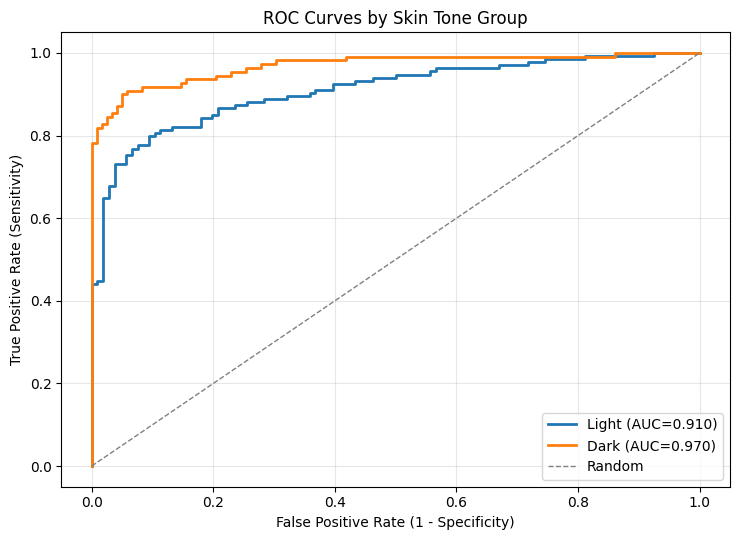

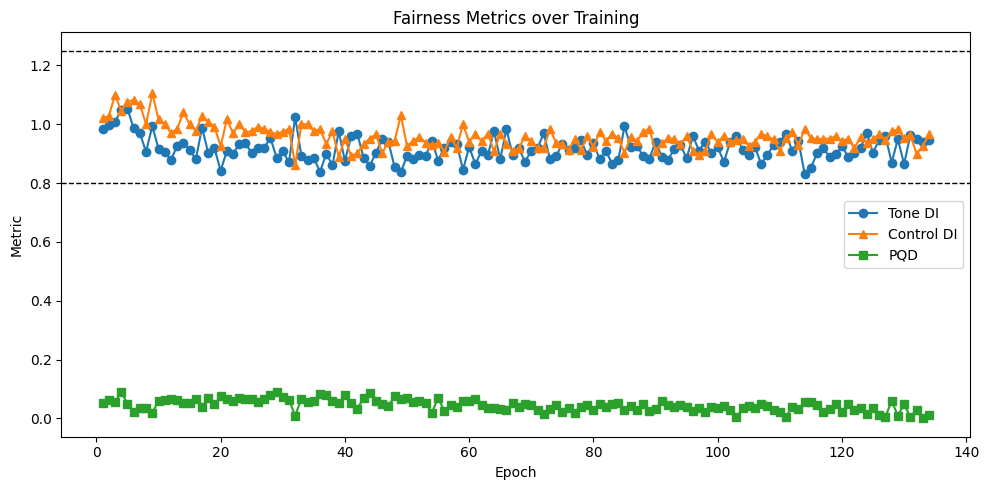

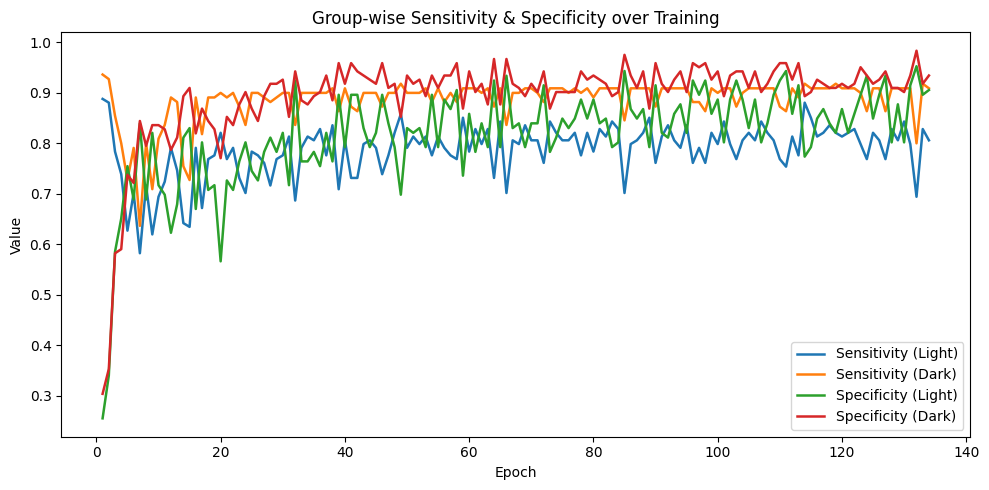

In [4]:
# ROC-AUC by group + ROC curves
def group_roc(df, name):
    if len(df)==0 or len(np.unique(df["y_true"]))<2:
        print(f"{name}: not enough positives/negatives for ROC.")
        return None, None, None, np.nan
    fpr, tpr, _ = roc_curve(df["y_true"], df["y_score"])
    group_auc = auc(fpr, tpr)
    return fpr, tpr, _, group_auc

fpr_L, tpr_L, _, auc_L = group_roc(light, "Light")
fpr_D, tpr_D, _, auc_D = group_roc(dark,  "Dark")
print(f"\nROC-AUC (Light) = {auc_L:.3f} | ROC-AUC (Dark) = {auc_D:.3f}")

# Plot ROC curves
plt.figure(figsize=(7.5,5.5))
if fpr_L is not None:
    plt.plot(fpr_L, tpr_L, lw=2, label=f"Light (AUC={auc_L:.3f})")
if fpr_D is not None:
    plt.plot(fpr_D, tpr_D, lw=2, label=f"Dark (AUC={auc_D:.3f})")
plt.plot([0,1],[0,1],'--', lw=1, color='gray', label='Random')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curves by Skin Tone Group")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("custom_cnn_ROC_balanced.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------
# Plot fairness over epochs
# -------------------
epochs = fair_cb.epochs
H = fair_cb.hist

# TDI, Control DI, PQD
plt.figure(figsize=(10,5))
plt.plot(epochs, H["tdi"], marker='o', lw=1.5, label="Tone DI")
plt.plot(epochs, H["cdi"], marker='^', lw=1.5, label="Control DI")
plt.plot(epochs, H["pqd"], marker='s', lw=1.5, label="PQD")
plt.axhline(0.8, color='k', linestyle='--', lw=1)
plt.axhline(1.25, color='k', linestyle='--', lw=1)
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Fairness Metrics over Training")
plt.legend()
plt.tight_layout()
plt.savefig("custom_cnn_balanced_tdi.png", dpi=300, bbox_inches="tight")
plt.show()

# Sensitivity/Specificity by group
plt.figure(figsize=(10,5))
plt.plot(epochs, H["sens_light"], lw=1.8, label="Sensitivity (Light)")
plt.plot(epochs, H["sens_dark"],  lw=1.8, label="Sensitivity (Dark)")
plt.plot(epochs, H["spec_light"], lw=1.8, label="Specificity (Light)")
plt.plot(epochs, H["spec_dark"],  lw=1.8, label="Specificity (Dark)")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Group-wise Sensitivity & Specificity over Training")
plt.legend()
plt.tight_layout()
plt.savefig("loss.png", dpi=300, bbox_inches="tight")
plt.show()


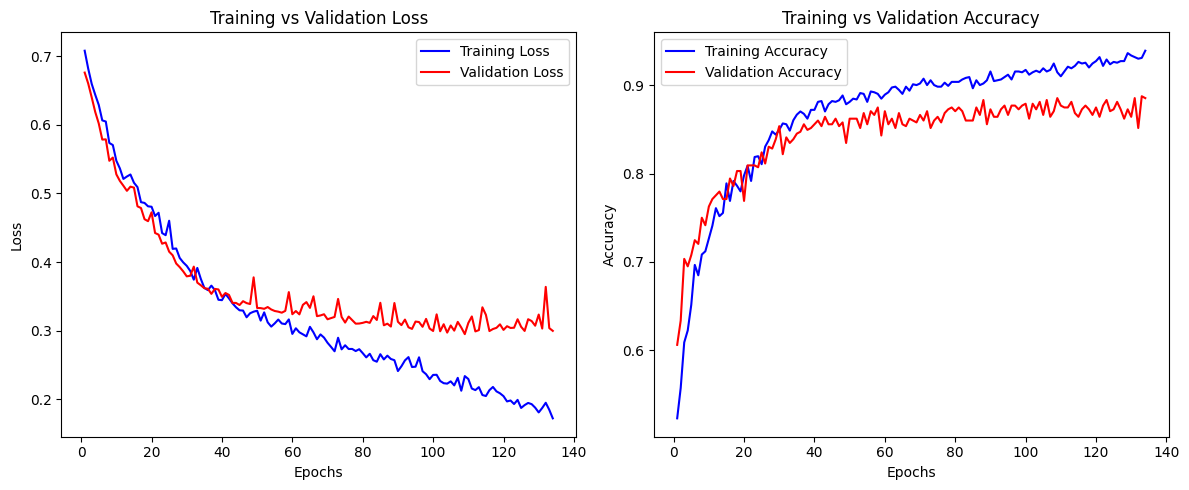

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Find best epoch (lowest val_loss)
best_epoch = np.argmin(val_loss) + 1

plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
#plt.axvline(best_epoch, color='g', linestyle='--', label=f'Early Stopping @ {best_epoch}')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# --- Plot Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
#plt.axvline(best_epoch, color='g', linestyle='--', label=f'Early Stopping @ {best_epoch}')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("custom_cnn_balance_loss.png", dpi=300, bbox_inches="tight")
plt.show()


Matthews Correlation Coefficient (overall): 0.7738

Confusion Matrix (labels: 0=Benign, 1=Malignant):
[[210  18]
 [ 36 208]]

TN=210  FP=18  FN=36  TP=208

Classification Report:
              precision    recall  f1-score   support

      Benign       0.85      0.92      0.89       228
   Malignant       0.92      0.85      0.89       244

    accuracy                           0.89       472
   macro avg       0.89      0.89      0.89       472
weighted avg       0.89      0.89      0.89       472



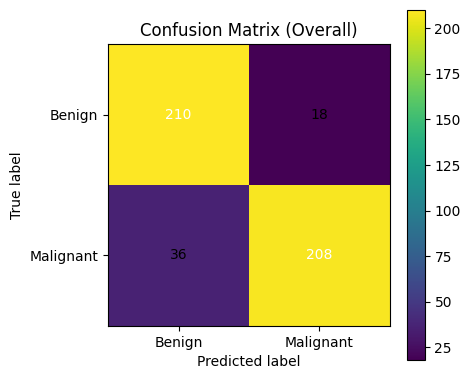

In [8]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_curve, auc, classification_report
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) Matthews Correlation Coefficient (overall) ----
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient (overall): {mcc:.4f}")

# ---- 2) Confusion Matrix (overall) ----
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix (labels: 0=Benign, 1=Malignant):")
print(cm)
print(f"\nTN={tn}  FP={fp}  FN={fn}  TP={tp}")

# Optional: classification report for completeness
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

# Optional: visualize confusion matrix
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Overall)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Benign","Malignant"])
plt.yticks(tick_marks, ["Benign","Malignant"])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# annotate counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.savefig("custom_cnn_balance_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()




Found 1104 validated image filenames.
Found 472 validated image filenames.


/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,609,666 (196.88 MB)

 Trainable params: 51,609,666 (196.88 MB)

 Non-trainable params: 0 (0.00 B)

/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5324 - loss: 0.6954
[Gender Fairness @ epoch 1] GDI=nan  CDI=1.015  PQD=0.000 | Female Sens=nan Spec=nan | Male Sens=nan Spec=nan
35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.5327 - loss: 0.6952 - val_accuracy: 0.5742 - val_loss: 0.6648
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6015 - loss: 0.6703
[Gender Fairness @ epoch 2] GDI=nan  CDI=1.011  PQD=0.000 | Female Sens=nan Spec=nan | Male Sens=nan Spec=nan
35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.6011 - loss: 0.6704 - val_accuracy: 0.6441 - val_loss: 0.6491

Confusion Matrix (overall):
 [[ 91 137]
 [ 31 213]]

Classification Report (overall):
               precision    recall  f1-score   support

      Benign       0.75      0.40      0.52       228
   Malignant       0.61      0.87      0.72       244

    accuracy                           0.64       472
   macro avg       0.68      0.64      0.62       472
weighted avg       0.67   

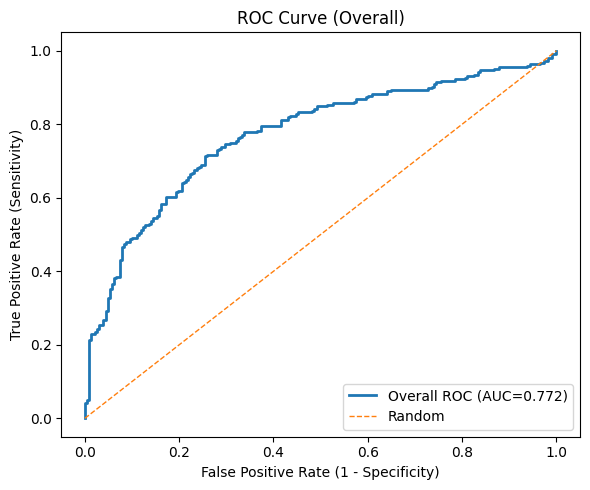

Female: not enough data for ROC.
Male: not enough data for ROC.


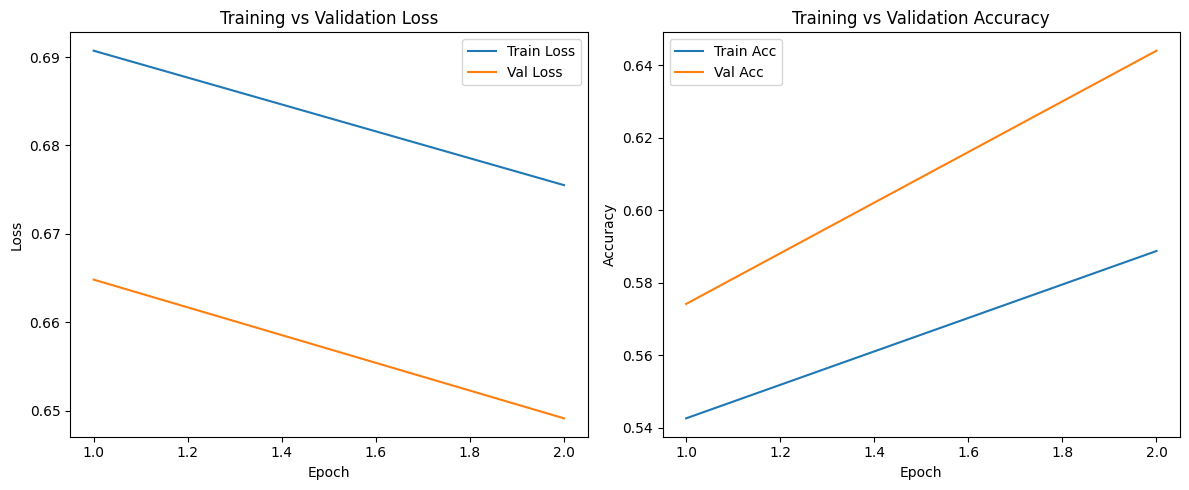

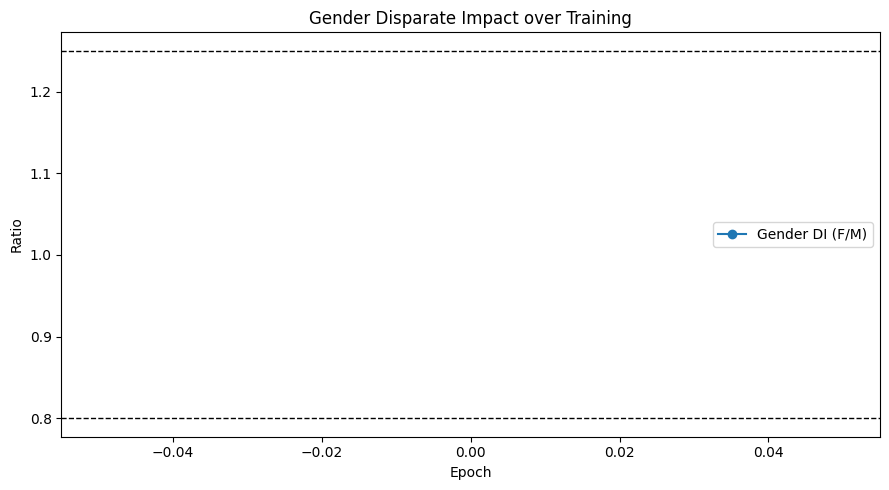

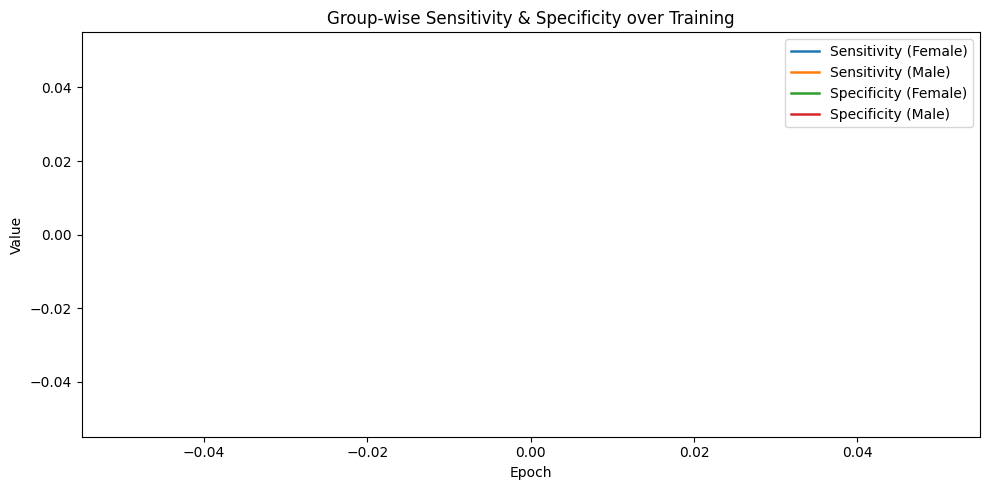

In [12]:
# ================================
# Skin Cancer CNN (Diagnosis) + Gender Fairness Suite
# ================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, precision_score)
from sklearn.utils import check_random_state

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# -------------------
# Config
# -------------------
CSV_PATH  = "/home/ec2-user/balanced_dataset.csv"
IMG_DIR   = "/home/ec2-user/balanced_dataset/"   # <- ensure this points to the folder with images
IMG_SIZE  = (224, 224)
BATCH     = 32
EPOCHS    = 2
LR        = 1e-5
SEED      = 42
VAL_SPLIT = 0.30
USE_VGG16 = False  # True to use VGG16 backbone + AlexNet-style head

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------------------
# Load dataframe
# -------------------
fair_df = pd.read_csv(CSV_PATH)

# Task labels: 0=Benign, 1=Malignant (keep diagnosis as the prediction target)
fair_df["label"] = fair_df["diagnosis_1"].map({"Benign": 0, "Malignant": 1}).astype(int)
fair_df["filename"] = fair_df["isic_id"].astype(str) + ".jpg"

# sanity checks (we will evaluate fairness by `sex`)
for col in ["filename", "label", "sex"]:
    if col not in fair_df.columns:
        raise ValueError(f"CSV must contain column: {col}")

# -------------------
# Optional Stable "Control" grouping (for a neutral DI sanity check)
# -------------------
rng = check_random_state(SEED)
fair_df["ControlGroup"] = fair_df["filename"].apply(lambda s: (hash(s) & 1))
fair_df["ControlGroup"] = fair_df["ControlGroup"].map({0: "A", 1: "B"})

# -------------------
# Generators (rescale only; no augmentation for reproducibility)
# -------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)

train_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="training",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",   # integer labels
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="validation",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",
    shuffle=False,
    seed=SEED
)

# -------------------
# Models
# -------------------
def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (7,7), activation='relu', padding='same', input_shape=(*IMG_SIZE,3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16_alexnet_head():
    from tensorflow.keras.applications import VGG16
    inp = Input(shape=(*IMG_SIZE,3))
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inp)
    # freeze a few early layers (optional)
    for layer in base.layers[:3]:
        layer.trainable = False
    x = Flatten(name="flatten")(base.output)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='drop1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='drop2')(x)
    x = BatchNormalization(name='bn')(x)
    out = Dense(2, activation='softmax', name='pred')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_vgg16_alexnet_head() if USE_VGG16 else build_simple_cnn()
model.summary()

# -------------------
# Gender Fairness Callback (protected attribute = sex)
# -------------------
class GenderFairnessCallback(Callback):
    """
    Per-epoch logs:
      - Gender Disparate Impact (selection rate Female/Male)
      - Control DI (selection rate Group A / Group B)
      - Group Sensitivity & Specificity (Female/Male)
      - Predictive Quality Disparity (|PPV_F - PPV_M|)
    """
    def __init__(self, val_gen, meta_df):
        super().__init__()
        self.val_gen = val_gen
        self.meta = meta_df[["filename","sex","ControlGroup"]].copy()
        self.hist = {k: [] for k in [
            "gdi","cdi","sens_f","sens_m","spec_f","spec_m","pqd"
        ]}
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()
        probs = self.model.predict(self.val_gen, verbose=0)   # (N,2)
        y_pred = probs.argmax(axis=1)
        y_true = self.val_gen.labels.astype(int)

        # Align predictions with filenames
        fnames = [os.path.basename(p) for p in self.val_gen.filenames]
        res = pd.DataFrame({"filename": fnames, "y_true": y_true, "y_pred": y_pred})
        merged = res.merge(self.meta, on="filename", how="left")

        male   = merged[merged["sex"]=="Male"]
        female = merged[merged["sex"]=="Female"]

        def sel_rate(df): 
            return (df["y_pred"]==1).mean() if len(df) else np.nan

        # Gender DI: selection rate Female / Male
        rate_f, rate_m = sel_rate(female), sel_rate(male)
        gdi = (rate_f / rate_m) if (rate_m and not np.isnan(rate_m)) else np.nan

        # Control DI (neutral check)
        grpA = merged[merged["ControlGroup"]=="A"]
        grpB = merged[merged["ControlGroup"]=="B"]
        rate_A, rate_B = sel_rate(grpA), sel_rate(grpB)
        cdi = (rate_A / rate_B) if (rate_B and not np.isnan(rate_B)) else np.nan

        # Sensitivity / Specificity by gender
        def sens_spec(df):
            if len(df)==0 or len(np.unique(df["y_true"]))<2:
                return np.nan, np.nan
            cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
            TN, FP, FN, TP = cm.ravel()
            sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
            spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
            return sens, spec

        sens_F, spec_F = sens_spec(female)
        sens_M, spec_M = sens_spec(male)

        # Predictive Quality Disparity (precision gap)
        def prec(df):
            return precision_score(df["y_true"], df["y_pred"], zero_division=0) if len(df) else 0.0
        pqd = abs(prec(female) - prec(male))

        # store logs
        self.epochs.append(epoch+1)
        self.hist["gdi"].append(gdi)
        self.hist["cdi"].append(cdi)
        self.hist["sens_f"].append(sens_F)
        self.hist["sens_m"].append(sens_M)
        self.hist["spec_f"].append(spec_F)
        self.hist["spec_m"].append(spec_M)
        self.hist["pqd"].append(pqd)

        print(f"\n[Gender Fairness @ epoch {epoch+1}] GDI={gdi:.3f}  CDI={cdi:.3f}  PQD={pqd:.3f} | "
              f"Female Sens={sens_F:.3f} Spec={spec_F:.3f} | Male Sens={sens_M:.3f} Spec={spec_M:.3f}")

meta_for_val = fair_df[["filename","sex","ControlGroup"]].copy()
fair_cb = GenderFairnessCallback(val_gen, meta_for_val)

# -------------------
# Training
# -------------------
early = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
ckpt  = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early, ckpt, fair_cb],
    verbose=1
)

# -------------------
# Final Evaluation
# -------------------
val_gen.reset()
probs = model.predict(val_gen, verbose=0)       # (N,2)
y_score = probs[:,1]                             # P(malignant)
y_pred  = probs.argmax(axis=1)
y_true  = val_gen.labels.astype(int)

print("\nConfusion Matrix (overall):\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report (overall):\n",
      classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

# Build merged_df for group analyses & plots
results_df = pd.DataFrame({
    "filename": [os.path.basename(f) for f in val_gen.filenames],
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_score
})
merged_df = results_df.merge(fair_df[["filename","sex","ControlGroup"]], on="filename", how="left")

# -------------------
# Gender Fairness Metrics (final)
# -------------------
male   = merged_df[merged_df["sex"]=="Male"]
female = merged_df[merged_df["sex"]=="Female"]

# Gender Disparate Impact: P(ŷ=1 | Female) / P(ŷ=1 | Male)
rate_f = (female["y_pred"]==1).mean() if len(female) else np.nan
rate_m = (male["y_pred"]==1).mean()   if len(male)   else np.nan
GDI = (rate_f / rate_m) if (isinstance(rate_m, float) and rate_m>0) else np.nan
print(f"\nFINAL Gender Disparate Impact = {GDI:.3f}")

# Predictive Quality Disparity (|PPV_F - PPV_M|)
prec_F = precision_score(female["y_true"], female["y_pred"], zero_division=0) if len(female) else np.nan
prec_M = precision_score(male["y_true"],   male["y_pred"],   zero_division=0) if len(male)   else np.nan
PQD = abs(prec_F - prec_M) if (not np.isnan(prec_F) and not np.isnan(prec_M)) else np.nan
print(f"FINAL Predictive Quality Disparity (|PPV_F - PPV_M|) = {PQD:.3f}")

# Sensitivity / Specificity by group
def sens_spec_cm(df):
    if len(df)==0 or len(np.unique(df["y_true"]))<2:
        return np.nan, np.nan, None
    cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
    spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
    return sens, spec, cm

sens_F, spec_F, cm_F = sens_spec_cm(female)
sens_M, spec_M, cm_M = sens_spec_cm(male)
print(f"\nFemale Sens={sens_F:.3f}  Spec={spec_F:.3f}  Confusion=\n{cm_F}")
print(f"Male   Sens={sens_M:.3f}  Spec={spec_M:.3f}  Confusion=\n{cm_M}")

# -------------------
# ROC curves (overall and by gender)
# -------------------
# Overall
fpr, tpr, _ = roc_curve(y_true, y_score)
auc_all = auc(fpr, tpr)
print(f"\nROC-AUC (overall): {auc_all:.3f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"Overall ROC (AUC={auc_all:.3f})")
plt.plot([0,1],[0,1],'--', lw=1, label="Random")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve (Overall)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_overall.png", dpi=300, bbox_inches="tight")
plt.show()

# By gender (only if both classes present)
for group_name, g in [("Female", female), ("Male", male)]:
    if len(g)==0 or len(np.unique(g["y_true"]))<2:
        print(f"{group_name}: not enough data for ROC.")
        continue
    fpr_g, tpr_g, _ = roc_curve(g["y_true"], g["y_score"])
    auc_g = auc(fpr_g, tpr_g)
    print(f"ROC-AUC ({group_name}): {auc_g:.3f}")
    plt.figure(figsize=(6,5))
    plt.plot(fpr_g, tpr_g, lw=2, label=f"{group_name} ROC (AUC={auc_g:.3f})")
    plt.plot([0,1],[0,1],'--', lw=1, label="Random")
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title(f"ROC Curve ({group_name})")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f"roc_{group_name.lower()}.png", dpi=300, bbox_inches="tight")
    plt.show()

# -------------------
# Training & Fairness curves (optional)
# -------------------
# Loss/Accuracy
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
epochs_hist = range(1, len(loss) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_hist, loss, label='Train Loss')
plt.plot(epochs_hist, val_loss, label='Val Loss')
plt.title("Training vs Validation Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_hist, acc, label='Train Acc')
plt.plot(epochs_hist, val_acc, label='Val Acc')
plt.title("Training vs Validation Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.tight_layout()
plt.savefig("train_val_curves.png", dpi=300, bbox_inches="tight")
plt.show()



Matthews Correlation Coefficient (overall): 0.3106

Confusion Matrix (labels: 0=Benign, 1=Malignant):
[[ 91 137]
 [ 31 213]]

TN=91  FP=137  FN=31  TP=213

Classification Report:
              precision    recall  f1-score   support

      Benign       0.75      0.40      0.52       228
   Malignant       0.61      0.87      0.72       244

    accuracy                           0.64       472
   macro avg       0.68      0.64      0.62       472
weighted avg       0.67      0.64      0.62       472



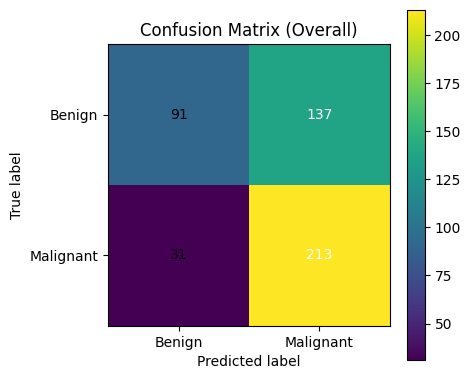

In [14]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_curve, auc, classification_report
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) Matthews Correlation Coefficient (overall) ----
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient (overall): {mcc:.4f}")

# ---- 2) Confusion Matrix (overall) ----
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix (labels: 0=Benign, 1=Malignant):")
print(cm)
print(f"\nTN={tn}  FP={fp}  FN={fn}  TP={tp}")

# Optional: classification report for completeness
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

# Optional: visualize confusion matrix
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Overall)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Benign","Malignant"])
plt.yticks(tick_marks, ["Benign","Malignant"])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# annotate counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.savefig("custom_cnn_balance_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()




In [28]:
# ================================
# Skin Cancer CNN + Fairness Suite (tone) + Gender Metrics
# ================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, precision_score,
                             accuracy_score, f1_score)
from sklearn.utils import check_random_state

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# -------------------
# Config
# -------------------
CSV_PATH  = "/home/ec2-user/balanced_dataset.csv"
IMG_DIR   = "/home/ec2-user/balanced_dataset/"   # <- folder with images
IMG_SIZE  = (224, 224)
BATCH     = 32
EPOCHS    = 60          # increase for full training (e.g., 100–350)
LR        = 1e-5
SEED      = 42
VAL_SPLIT = 0.30
USE_VGG16 = False       # True -> VGG16 backbone with AlexNet-style head

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------------------
# Load dataframe
# -------------------
fair_df = pd.read_csv(CSV_PATH)

# Labels: 0=Benign, 1=Malignant
fair_df["label"] = fair_df["diagnosis_1"].map({"Benign": 0, "Malignant": 1}).astype(int)
fair_df["filename"] = fair_df["isic_id"].astype(str) + ".jpg"

for col in ["filename", "label", "FST_Skintone", "sex"]:
    if col not in fair_df.columns:
        raise ValueError(f"CSV must contain column: {col}")

# Stable control groups for sanity-check DI
rng = check_random_state(SEED)
fair_df["ControlGroup"] = fair_df["filename"].apply(lambda s: (hash(s) & 1))
fair_df["ControlGroup"] = fair_df["ControlGroup"].map({0: "A", 1: "B"})

# -------------------
# Generators (rescale only for reproducibility)
# -------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)

train_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="training",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",   # integer labels
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="validation",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",
    shuffle=False,
    seed=SEED
)

# -------------------
# Models
# -------------------
def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (7,7), activation='relu', padding='same', input_shape=(*IMG_SIZE,3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16_alexnet_head():
    from tensorflow.keras.applications import VGG16
    inp = Input(shape=(*IMG_SIZE,3))
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inp)
    for layer in base.layers[:3]:   # lightly freeze early layers
        layer.trainable = False
    x = Flatten(name="flatten")(base.output)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='drop1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='drop2')(x)
    x = BatchNormalization(name='bn')(x)
    out = Dense(2, activation='softmax', name='pred')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_vgg16_alexnet_head() if USE_VGG16 else build_simple_cnn()
model.summary()

# -------------------
# Tone Fairness Callback (TDI, Sens/Spec, PQD)
# -------------------
class FairnessCallback(Callback):
    def __init__(self, val_gen, meta_df):
        super().__init__()
        self.val_gen = val_gen
        self.meta = meta_df[["filename","FST_Skintone","ControlGroup"]].copy()
        self.hist = {k: [] for k in
                     ["tdi","cdi","sens_light","sens_dark","spec_light","spec_dark","pqd"]}
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()
        probs = self.model.predict(self.val_gen, verbose=0)   # (N,2)
        y_pred = probs.argmax(axis=1)
        y_true = self.val_gen.labels.astype(int)

        fnames = [os.path.basename(p) for p in self.val_gen.filenames]
        merged = pd.DataFrame({"filename": fnames, "y_true": y_true, "y_pred": y_pred}) \
                 .merge(self.meta, on="filename", how="left")

        dark  = merged[merged["FST_Skintone"]=="Dark"]
        light = merged[merged["FST_Skintone"]=="Light"]

        def sel_rate(df): 
            return (df["y_pred"]==1).mean() if len(df) else np.nan

        rate_dark, rate_light = sel_rate(dark), sel_rate(light)
        tdi = rate_dark / rate_light if pd.notnull(rate_dark) and pd.notnull(rate_light) and rate_light>0 else np.nan

        grpA = merged[merged["ControlGroup"]=="A"]
        grpB = merged[merged["ControlGroup"]=="B"]
        rate_A, rate_B = sel_rate(grpA), sel_rate(grpB)
        cdi = rate_A / rate_B if pd.notnull(rate_A) and pd.notnull(rate_B) and rate_B>0 else np.nan

        def sens_spec(df):
            if len(df)==0 or len(np.unique(df["y_true"]))<2:
                return np.nan, np.nan
            cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
            TN, FP, FN, TP = cm.ravel()
            sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
            spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
            return sens, spec

        sens_L, spec_L = sens_spec(light)
        sens_D, spec_D = sens_spec(dark)

        def prec(df):
            return precision_score(df["y_true"], df["y_pred"], zero_division=0) if len(df) else 0.0
        pqd = abs(prec(light) - prec(dark))

        self.epochs.append(epoch+1)
        self.hist["tdi"].append(tdi)
        self.hist["cdi"].append(cdi)
        self.hist["sens_light"].append(sens_L)
        self.hist["sens_dark"].append(sens_D)
        self.hist["spec_light"].append(spec_L)
        self.hist["spec_dark"].append(spec_D)
        self.hist["pqd"].append(pqd)

        print(f"\n[Fairness @ epoch {epoch+1}] TDI={tdi:.3f}  CDI={cdi:.3f}  PQD={pqd:.3f} | "
              f"Light Sens={sens_L:.3f} Spec={spec_L:.3f} | Dark Sens={sens_D:.3f} Spec={spec_D:.3f}")

meta_for_val = fair_df[["filename","FST_Skintone","ControlGroup"]].copy()
fair_cb = FairnessCallback(val_gen, meta_for_val)

# -------------------
# Training
# -------------------
early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
ckpt  = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early, ckpt, fair_cb],
    verbose=1
)

# -------------------
# Final Evaluation (overall)
# -------------------
val_gen.reset()
probs   = model.predict(val_gen, verbose=0)       # (N,2)
y_prob  = probs[:,1]                              # P(malignant)
y_pred  = probs.argmax(axis=1)
y_true  = val_gen.labels.astype(int)

print("\nConfusion Matrix (overall):\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report (overall):\n",
      classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

# Build merged_df for all group analyses (tone + gender)
results_df = pd.DataFrame({
    "filename": [os.path.basename(f) for f in val_gen.filenames],
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_prob
})
merged_df = results_df.merge(
    fair_df[["filename","FST_Skintone","ControlGroup","sex"]],
    on="filename", how="left"
)

# -------------------
# Skin Tone metrics (final)
# -------------------
dark  = merged_df[merged_df["FST_Skintone"]=="Dark"]
light = merged_df[merged_df["FST_Skintone"]=="Light"]

rate_dark  = (dark["y_pred"]==1).mean()  if len(dark)  else np.nan
rate_light = (light["y_pred"]==1).mean() if len(light) else np.nan
TDI = rate_dark / rate_light if pd.notnull(rate_dark) and pd.notnull(rate_light) and rate_light>0 else np.nan
print(f"\nFINAL Tone Disparate Impact = {TDI:.3f}")




   


Found 1104 validated image filenames.
Found 472 validated image filenames.


/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 224, 224, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,609,666 (196.88 MB)

 Trainable params: 51,609,666 (196.88 MB)

 Non-trainable params: 0 (0.00 B)

/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5166 - loss: 0.7001
[Fairness @ epoch 1] TDI=1.034  CDI=nan  PQD=1.000 | Light Sens=0.000 Spec=0.991 | Dark Sens=0.009 Spec=1.000
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.5168 - loss: 0.7001 - val_accuracy: 0.4831 - val_loss: 0.6868
Epoch 2/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5207 - loss: 0.6940
[Fairness @ epoch 2] TDI=0.546  CDI=1.037  PQD=0.086 | Light Sens=0.231 Spec=0.953 | Dark Sens=0.164 Spec=0.992
35/35 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5216 - loss: 0.6937 - val_accuracy: 0.5742 - val_loss: 0.6667
Epoch 3/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5692 - loss: 0.6739
[Fairness @ epoch 3] TDI=0.812  CDI=0.880  PQD=0.080 | Light Sens=0.485 Spec=0.868 | Dark Sens=0.509 Spec=0.951
35/35 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.5698 - loss: 0.6738 - val_accuracy: 0.6970 - val_loss: 0.6475
Epoch 4/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6348 - lo

In [29]:
# === Per-Gender metrics: Accuracy, F1 (Malignant=1), MCC ===
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix

# 1) Ensure `sex` is standardized and present
if "sex" not in merged_df.columns:
    raise ValueError("merged_df must contain a 'sex' column for gender analysis.")

merged_df["sex"] = merged_df["sex"].astype(str).str.strip().str.title()  # 'male'->'Male', etc.
merged_df = merged_df[merged_df["sex"].isin(["Male","Female"])].copy()

# 2) Helper to compute metrics for a subset
def compute_metrics_by_group(df, group_label):
    out = {"Group": group_label, "n": len(df)}
    if len(df) == 0:
        out.update({"Accuracy": np.nan, "F1 (Malignant)": np.nan, "MCC": np.nan})
        return out

    y_t = df["y_true"].to_numpy()
    y_p = df["y_pred"].to_numpy()

    acc = accuracy_score(y_t, y_p)
    f1  = f1_score(y_t, y_p, pos_label=1, zero_division=0)     # malignant=1
    mcc = matthews_corrcoef(y_t, y_p) if len(np.unique(y_t))==2 else np.nan

    out.update({"Accuracy": acc, "F1 (Malignant)": f1, "MCC": mcc})
    return out

# 3) Split and compute
male_df   = merged_df[merged_df["sex"] == "Male"]
female_df = merged_df[merged_df["sex"] == "Female"]

rows = [
    compute_metrics_by_group(male_df, "Male"),
    compute_metrics_by_group(female_df, "Female"),
]
gender_metrics = pd.DataFrame(rows).set_index("Group")

# 4) Print & save
print("\n=== Per-Gender Performance (Diagnosis task: Malignant=1) ===")
print(gender_metrics)

gender_metrics.to_csv("gender_metrics_acc_f1_mcc.csv")
with open("gender_metrics_acc_f1_mcc.tex", "w") as f:
    f.write(gender_metrics.to_latex(float_format="%.4f"))
print("Saved: gender_metrics_acc_f1_mcc.csv, gender_metrics_acc_f1_mcc.tex")

# (Optional) Per-gender confusion matrices for your appendix
for grp, df in [("Male", male_df), ("Female", female_df)]:
    if len(df) == 0:
        print(f"\n[{grp}] No samples.")
        continue
    cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
    print(f"\n[{grp}] Confusion Matrix (0=Benign, 1=Malignant):\n{cm}")



=== Per-Gender Performance (Diagnosis task: Malignant=1) ===
          n  Accuracy  F1 (Malignant)       MCC
Group                                          
Male    242  0.834711        0.843750  0.673948
Female  227  0.889868        0.883721  0.779153
Saved: gender_metrics_acc_f1_mcc.csv, gender_metrics_acc_f1_mcc.tex

[Male] Confusion Matrix (0=Benign, 1=Malignant):
[[ 94  13]
 [ 27 108]]

[Female] Confusion Matrix (0=Benign, 1=Malignant):
[[107  12]
 [ 13  95]]


In [ ]:
#VGG16- balanced

In [1]:
# ================================
# Skin Cancer CNN + Fairness Suite
# ================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_score
from sklearn.utils import check_random_state

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# -------------------
# Config
# -------------------
CSV_PATH  = "/home/ec2-user/balanced_dataset.csv"
IMG_DIR   = "/home/ec2-user/balanced_dataset/"
IMG_SIZE  = (224, 224)
BATCH     = 32
EPOCHS    = 80
LR        = 1e-5
SEED      = 42
VAL_SPLIT = 0.30
USE_VGG16 = True  # set True to use VGG16 backbone with AlexNet-style head

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------------------
# Load dataframe
# -------------------
fair_df = pd.read_csv(CSV_PATH)
# Labels: 0=Benign, 1=Malignant
fair_df["label"] = fair_df["diagnosis_1"].map({"Benign": 0, "Malignant": 1}).astype(int)
fair_df["filename"] = fair_df["isic_id"].astype(str) + ".jpg"

# sanity checks
for col in ["filename", "label", "FST_Skintone"]:
    if col not in fair_df.columns:
        raise ValueError(f"CSV must contain column: {col}")

# -------------------
# Add a stable "Control" grouping (for Control DI)
# -------------------
rng = check_random_state(SEED)
# deterministic 0/1 assignment based on filename hash
fair_df["ControlGroup"] = fair_df["filename"].apply(lambda s: (hash(s) & 1))
fair_df["ControlGroup"] = fair_df["ControlGroup"].map({0: "A", 1: "B"})

# -------------------
# Generators (no augmentation; rescale only)
# -------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)

train_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="training",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",   # returns integer labels
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="validation",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",
    shuffle=False,
    seed=SEED
)

# -------------------
# Models
# -------------------
def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (7,7), activation='relu', padding='same', input_shape=(*IMG_SIZE,3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16_alexnet_head():
    from tensorflow.keras.applications import VGG16
    inp = Input(shape=(*IMG_SIZE,3))
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inp)
    # freeze a few early layers (optional)
    for layer in base.layers[:3]:
        layer.trainable = False
    x = Flatten(name="flatten")(base.output)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='drop1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='drop2')(x)
    x = BatchNormalization(name='bn')(x)
    out = Dense(2, activation='softmax', name='pred')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_vgg16_alexnet_head() if USE_VGG16 else build_simple_cnn()
model.summary()

# -------------------
# Fairness Callback
# -------------------
class FairnessCallback(Callback):
    """
    Logs per-epoch:
      - Tone Disparate Impact (selection rate Dark/Light)
      - Control DI (selection rate GroupA/GroupB)
      - Group Sensitivity & Specificity
      - Predictive Quality Disparity (|PPV_L - PPV_D|)
    """
    def __init__(self, val_gen, meta_df):
        super().__init__()
        self.val_gen = val_gen
        self.meta = meta_df[["filename","FST_Skintone","ControlGroup"]].copy()
        self.hist = {k: [] for k in [
            "tdi","cdi","sens_light","sens_dark","spec_light","spec_dark","pqd"
        ]}
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()
        probs = self.model.predict(self.val_gen, verbose=0)   # (N,2)
        y_pred = probs.argmax(axis=1)
        y_true = self.val_gen.labels.astype(int)              # DataFrameIterator -> .labels

        # Merge preds with meta (align by filenames order)
        fnames = [os.path.basename(p) for p in self.val_gen.filenames]
        res = pd.DataFrame({"filename": fnames, "y_true": y_true, "y_pred": y_pred})
        merged = res.merge(self.meta, on="filename", how="left")

        # Selection rates
        def sel_rate(df): 
            return (df["y_pred"]==1).mean() if len(df) else np.nan
        dark  = merged[merged["FST_Skintone"]=="Dark"]
        light = merged[merged["FST_Skintone"]=="Light"]
        rate_dark, rate_light = sel_rate(dark), sel_rate(light)
        tdi = (rate_dark / rate_light) if (rate_light and not np.isnan(rate_light)) else np.nan

        grpA = merged[merged["ControlGroup"]=="A"]
        grpB = merged[merged["ControlGroup"]=="B"]
        rate_A, rate_B = sel_rate(grpA), sel_rate(grpB)
        cdi = (rate_A / rate_B) if (rate_B and not np.isnan(rate_B)) else np.nan

        # Sensitivity / Specificity by tone
        def sens_spec(df):
            if len(df)==0 or len(np.unique(df["y_true"]))<2:
                return np.nan, np.nan
            cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
            TN, FP, FN, TP = cm.ravel()
            sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
            spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
            return sens, spec

        sens_L, spec_L = sens_spec(light)
        sens_D, spec_D = sens_spec(dark)

        # Predictive Quality Disparity (difference in precision)
        def prec(df):
            if len(df)==0 or (df["y_pred"]==1).sum()==0:
                return 0.0
            return precision_score(df["y_true"], df["y_pred"], zero_division=0)
        pqd = abs(prec(light) - prec(dark))

        # store
        self.epochs.append(epoch+1)
        self.hist["tdi"].append(tdi)
        self.hist["cdi"].append(cdi)
        self.hist["sens_light"].append(sens_L)
        self.hist["sens_dark"].append(sens_D)
        self.hist["spec_light"].append(spec_L)
        self.hist["spec_dark"].append(spec_D)
        self.hist["pqd"].append(pqd)

        print(f"\n[Fairness @ epoch {epoch+1}] TDI={tdi:.3f}  CDI={cdi:.3f}  PQD={pqd:.3f} | "
              f"Light Sens={sens_L:.3f} Spec={spec_L:.3f} | Dark Sens={sens_D:.3f} Spec={spec_D:.3f}")

# meta for callback
meta_for_val = fair_df[["filename","FST_Skintone","ControlGroup"]].copy()
fair_cb = FairnessCallback(val_gen, meta_for_val)

# -------------------
# Training
# -------------------
early = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
ckpt  = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early, ckpt, fair_cb],
    verbose=1
)

# -------------------
# Final Evaluation
# -------------------
val_gen.reset()
probs = model.predict(val_gen, verbose=0)       # (N,2)
y_prob = probs[:,1]                              # P(malignant)
y_pred = probs.argmax(axis=1)
y_true = val_gen.labels.astype(int)

print("\nConfusion Matrix (overall):\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report (overall):\n", classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

# Build merged_df for group analyses & plots
results_df = pd.DataFrame({
    "filename": [os.path.basename(f) for f in val_gen.filenames],
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_prob
})
merged_df = results_df.merge(fair_df[["filename","FST_Skintone","ControlGroup"]], on="filename", how="left")

# TDI (final)
dark  = merged_df[merged_df["FST_Skintone"]=="Dark"]
light = merged_df[merged_df["FST_Skintone"]=="Light"]
rate_dark  = (dark["y_pred"]==1).mean()
rate_light = (light["y_pred"]==1).mean()
TDI = (rate_dark / rate_light) if rate_light>0 else np.nan
print(f"\nFINAL Tone Disparate Impact = {TDI:.3f}")

# PQD (final)
prec_L = precision_score(light["y_true"], light["y_pred"], zero_division=0) if len(light) else np.nan
prec_D = precision_score(dark["y_true"],  dark["y_pred"],  zero_division=0) if len(dark)  else np.nan
PQD = abs(prec_L - prec_D)
print(f"FINAL Predictive Quality Disparity (|PPV_L - PPV_D|) = {PQD:.3f}")

# Sens/Spec by group (final)
def sens_spec(df):
    if len(df)==0 or len(np.unique(df["y_true"]))<2:
        return np.nan, np.nan, None
    cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
    spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
    return sens, spec, cm

sens_L, spec_L, cm_L = sens_spec(light)
sens_D, spec_D, cm_D = sens_spec(dark)
print(f"\nLight  Sens={sens_L:.3f}  Spec={spec_L:.3f}  Confusion=\n{cm_L}")
print(f"Dark   Sens={sens_D:.3f}  Spec={spec_D:.3f}  Confusion=\n{cm_D}")



2025-08-27 19:16:18.792542: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 19:16:18.808813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756322178.828592   70402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756322178.834631   70402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-27 19:16:18.855089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 1104 validated image filenames.
Found 472 validated image filenames.


I0000 00:00:1756322180.814888   70402 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn (BatchNormalization)         │ (None, 4096)           │        16,38

 Total params: 134,285,122 (512.26 MB)

 Trainable params: 134,238,210 (512.08 MB)

 Non-trainable params: 46,912 (183.25 KB)

/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80


I0000 00:00:1756322190.127541   70718 service.cc:148] XLA service 0x7f535001f070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756322190.127575   70718 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-08-27 19:16:30.213259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756322190.770767   70718 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-08-27 19:16:31.465906: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activa

12/35 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4755 - loss: 1.0517

2025-08-27 19:17:11.873530: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-27 19:17:11.943598: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5072 - loss: 0.9727

2025-08-27 19:18:03.373122: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,112,112]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-27 19:18:04.452072: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,112,112]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$c


[Fairness @ epoch 1] TDI=1.020  CDI=0.965  PQD=0.111 | Light Sens=0.993 Spec=0.255 | Dark Sens=0.982 Spec=0.172
35/35 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.5086 - loss: 0.9699 - val_accuracy: 0.6123 - val_loss: 0.6155
Epoch 2/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7310 - loss: 0.6176
[Fairness @ epoch 2] TDI=0.930  CDI=1.010  PQD=0.053 | Light Sens=0.970 Spec=0.443 | Dark Sens=0.982 Spec=0.492
35/35 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.7314 - loss: 0.6166 - val_accuracy: 0.7309 - val_loss: 0.5335
Epoch 3/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7957 - loss: 0.4503
[Fairness @ epoch 3] TDI=0.901  CDI=0.956  PQD=0.003 | Light Sens=0.903 Spec=0.679 | Dark Sens=0.955 Spec=0.754
35/35 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7960 - loss: 0.4504 - val_accuracy: 0.8263 - val_loss: 0.3829
Epoch 4/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8481 - loss: 0.4023
[Fairness @ epoch 4] TDI=0.876  CDI=0.930  PQD=0.025 | Light Sens=0.

In [2]:
from sklearn.metrics import matthews_corrcoef, roc_curve, auc

for group in ["Light","Dark"]:
    g = merged_df[merged_df["FST_Skintone"] == group]
    if len(g) == 0 or len(np.unique(g["y_true"])) < 2:
        print(f"{group}: not enough data for ROC/MCC.")
        continue
    mcc_g = matthews_corrcoef(g["y_true"], g["y_pred"])
    fpr_g, tpr_g, _ = roc_curve(g["y_true"], g["y_score"])
    auc_g = auc(fpr_g, tpr_g)
    print(f"{group} → MCC: {mcc_g:.4f} | AUC: {auc_g:.4f}")


Light → MCC: 0.7684 | AUC: 0.9481
Dark → MCC: 0.8704 | AUC: 0.9822


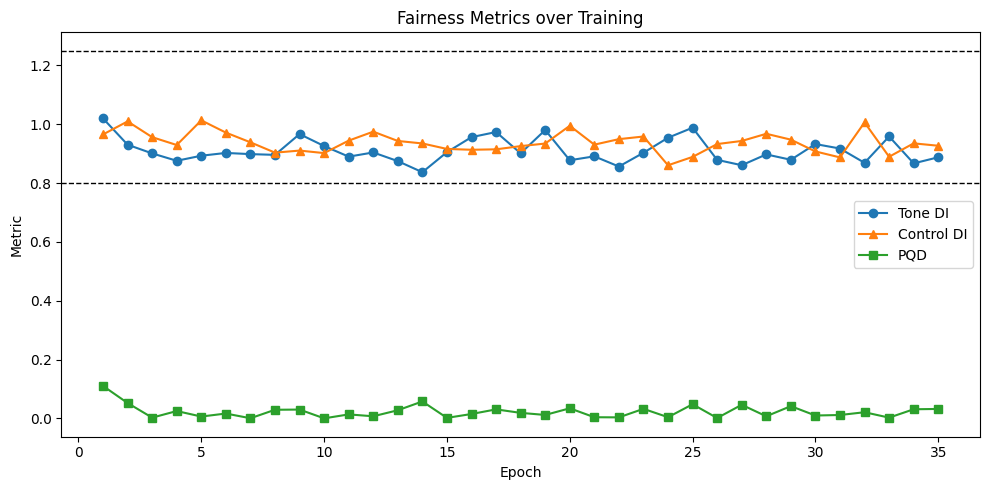

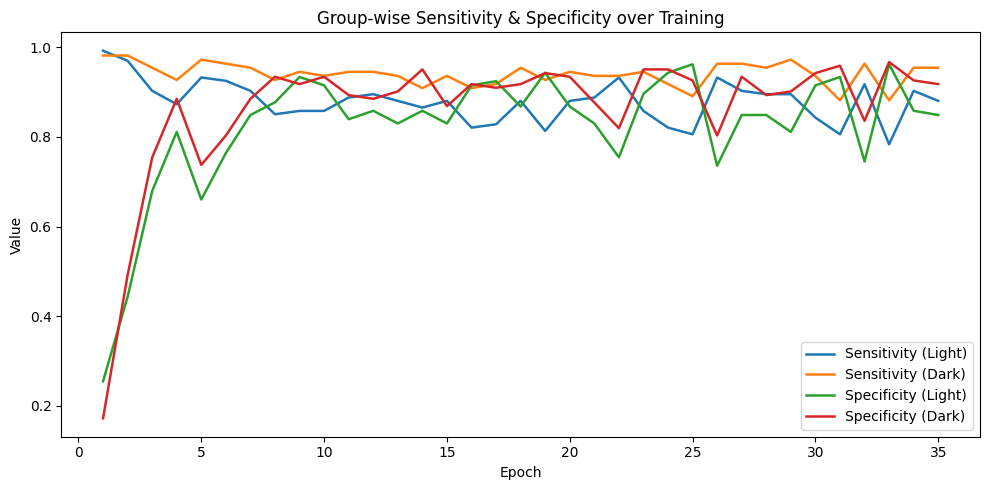

In [3]:
# -------------------
# Plot fairness over epochs
# -------------------
epochs = fair_cb.epochs
H = fair_cb.hist

# TDI, Control DI, PQD
plt.figure(figsize=(10,5))
plt.plot(epochs, H["tdi"], marker='o', lw=1.5, label="Tone DI")
plt.plot(epochs, H["cdi"], marker='^', lw=1.5, label="Control DI")
plt.plot(epochs, H["pqd"], marker='s', lw=1.5, label="PQD")
plt.axhline(0.8, color='k', linestyle='--', lw=1)
plt.axhline(1.25, color='k', linestyle='--', lw=1)
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Fairness Metrics over Training")
plt.legend()
plt.tight_layout()
plt.show()

# Sensitivity/Specificity by group
plt.figure(figsize=(10,5))
plt.plot(epochs, H["sens_light"], lw=1.8, label="Sensitivity (Light)")
plt.plot(epochs, H["sens_dark"],  lw=1.8, label="Sensitivity (Dark)")
plt.plot(epochs, H["spec_light"], lw=1.8, label="Specificity (Light)")
plt.plot(epochs, H["spec_dark"],  lw=1.8, label="Specificity (Dark)")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Group-wise Sensitivity & Specificity over Training")
plt.legend()
plt.tight_layout()
plt.savefig("vgg_cnn_imbalance_fairness.png", dpi=300, bbox_inches="tight")
plt.show()


##Custom CNN - imbalanced

In [1]:
# ================================
# Skin Cancer CNN + Fairness Suite
# ================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_score
from sklearn.utils import check_random_state

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# -------------------
# Config
# -------------------
CSV_PATH  = "/home/ec2-user/imbalanced_dataset.csv"
IMG_DIR   = "/home/ec2-user/imbalanced_dataset"
IMG_SIZE  = (224, 224)
BATCH     = 32
EPOCHS    = 80
LR        = 1e-5
SEED      = 42
VAL_SPLIT = 0.30
USE_VGG16 = False  # set True to use VGG16 backbone with AlexNet-style head

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------------------
# Load dataframe
# -------------------
fair_df = pd.read_csv(CSV_PATH)
# Labels: 0=Benign, 1=Malignant
fair_df["label"] = fair_df["diagnosis_1"].map({"Benign": 0, "Malignant": 1}).astype(int)
fair_df["filename"] = fair_df["isic_id"].astype(str) + ".jpg"

# sanity checks
for col in ["filename", "label", "FST_Skintone"]:
    if col not in fair_df.columns:
        raise ValueError(f"CSV must contain column: {col}")

# -------------------
# Add a stable "Control" grouping (for Control DI)
# -------------------
rng = check_random_state(SEED)
# deterministic 0/1 assignment based on filename hash
fair_df["ControlGroup"] = fair_df["filename"].apply(lambda s: (hash(s) & 1))
fair_df["ControlGroup"] = fair_df["ControlGroup"].map({0: "A", 1: "B"})

# -------------------
# Generators (no augmentation; rescale only)
# -------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)

train_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="training",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",   # returns integer labels
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_dataframe(
    dataframe=fair_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    subset="validation",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="raw",
    shuffle=False,
    seed=SEED
)

# -------------------
# Models
# -------------------
def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (7,7), activation='relu', padding='same', input_shape=(*IMG_SIZE,3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16_alexnet_head():
    from tensorflow.keras.applications import VGG16
    inp = Input(shape=(*IMG_SIZE,3))
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inp)
    # freeze a few early layers (optional)
    for layer in base.layers[:3]:
        layer.trainable = False
    x = Flatten(name="flatten")(base.output)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='drop1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='drop2')(x)
    x = BatchNormalization(name='bn')(x)
    out = Dense(2, activation='softmax', name='pred')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_vgg16_alexnet_head() if USE_VGG16 else build_simple_cnn()
model.summary()

# -------------------
# Fairness Callback
# -------------------
class FairnessCallback(Callback):
    """
    Logs per-epoch:
      - Tone Disparate Impact (selection rate Dark/Light)
      - Control DI (selection rate GroupA/GroupB)
      - Group Sensitivity & Specificity
      - Predictive Quality Disparity (|PPV_L - PPV_D|)
    """
    def __init__(self, val_gen, meta_df):
        super().__init__()
        self.val_gen = val_gen
        self.meta = meta_df[["filename","FST_Skintone","ControlGroup"]].copy()
        self.hist = {k: [] for k in [
            "tdi","cdi","sens_light","sens_dark","spec_light","spec_dark","pqd"
        ]}
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()
        probs = self.model.predict(self.val_gen, verbose=0)   # (N,2)
        y_pred = probs.argmax(axis=1)
        y_true = self.val_gen.labels.astype(int)              # DataFrameIterator -> .labels

        # Merge preds with meta (align by filenames order)
        fnames = [os.path.basename(p) for p in self.val_gen.filenames]
        res = pd.DataFrame({"filename": fnames, "y_true": y_true, "y_pred": y_pred})
        merged = res.merge(self.meta, on="filename", how="left")

        # Selection rates
        def sel_rate(df): 
            return (df["y_pred"]==1).mean() if len(df) else np.nan
        dark  = merged[merged["FST_Skintone"]=="Dark"]
        light = merged[merged["FST_Skintone"]=="Light"]
        rate_dark, rate_light = sel_rate(dark), sel_rate(light)
        tdi = (rate_dark / rate_light) if (rate_light and not np.isnan(rate_light)) else np.nan

        grpA = merged[merged["ControlGroup"]=="A"]
        grpB = merged[merged["ControlGroup"]=="B"]
        rate_A, rate_B = sel_rate(grpA), sel_rate(grpB)
        cdi = (rate_A / rate_B) if (rate_B and not np.isnan(rate_B)) else np.nan

        # Sensitivity / Specificity by tone
        def sens_spec(df):
            if len(df)==0 or len(np.unique(df["y_true"]))<2:
                return np.nan, np.nan
            cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
            TN, FP, FN, TP = cm.ravel()
            sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
            spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
            return sens, spec

        sens_L, spec_L = sens_spec(light)
        sens_D, spec_D = sens_spec(dark)

        # Predictive Quality Disparity (difference in precision)
        def prec(df):
            if len(df)==0 or (df["y_pred"]==1).sum()==0:
                return 0.0
            return precision_score(df["y_true"], df["y_pred"], zero_division=0)
        pqd = abs(prec(light) - prec(dark))

        # store
        self.epochs.append(epoch+1)
        self.hist["tdi"].append(tdi)
        self.hist["cdi"].append(cdi)
        self.hist["sens_light"].append(sens_L)
        self.hist["sens_dark"].append(sens_D)
        self.hist["spec_light"].append(spec_L)
        self.hist["spec_dark"].append(spec_D)
        self.hist["pqd"].append(pqd)

        print(f"\n[Fairness @ epoch {epoch+1}] TDI={tdi:.3f}  CDI={cdi:.3f}  PQD={pqd:.3f} | "
              f"Light Sens={sens_L:.3f} Spec={spec_L:.3f} | Dark Sens={sens_D:.3f} Spec={spec_D:.3f}")

# meta for callback
meta_for_val = fair_df[["filename","FST_Skintone","ControlGroup"]].copy()
fair_cb = FairnessCallback(val_gen, meta_for_val)

# -------------------
# Training
# -------------------
early = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
ckpt  = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early, ckpt, fair_cb],
    verbose=1
)

# -------------------
# Final Evaluation
# -------------------
val_gen.reset()
probs = model.predict(val_gen, verbose=0)       # (N,2)
y_prob = probs[:,1]                              # P(malignant)
y_pred = probs.argmax(axis=1)
y_true = val_gen.labels.astype(int)

print("\nConfusion Matrix (overall):\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report (overall):\n", classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

# Build merged_df for group analyses & plots
results_df = pd.DataFrame({
    "filename": [os.path.basename(f) for f in val_gen.filenames],
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_prob
})
merged_df = results_df.merge(fair_df[["filename","FST_Skintone","ControlGroup"]], on="filename", how="left")

# TDI (final)
dark  = merged_df[merged_df["FST_Skintone"]=="Dark"]
light = merged_df[merged_df["FST_Skintone"]=="Light"]
rate_dark  = (dark["y_pred"]==1).mean()
rate_light = (light["y_pred"]==1).mean()
TDI = (rate_dark / rate_light) if rate_light>0 else np.nan
print(f"\nFINAL Tone Disparate Impact = {TDI:.3f}")

# PQD (final)
prec_L = precision_score(light["y_true"], light["y_pred"], zero_division=0) if len(light) else np.nan
prec_D = precision_score(dark["y_true"],  dark["y_pred"],  zero_division=0) if len(dark)  else np.nan
PQD = abs(prec_L - prec_D)
print(f"FINAL Predictive Quality Disparity (|PPV_L - PPV_D|) = {PQD:.3f}")

# Sens/Spec by group (final)
def sens_spec(df):
    if len(df)==0 or len(np.unique(df["y_true"]))<2:
        return np.nan, np.nan, None
    cm = confusion_matrix(df["y_true"], df["y_pred"], labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
    spec = TN/(TN+FP) if (TN+FP)>0 else np.nan
    return sens, spec, cm

sens_L, spec_L, cm_L = sens_spec(light)
sens_D, spec_D, cm_D = sens_spec(dark)
print(f"\nLight  Sens={sens_L:.3f}  Spec={spec_L:.3f}  Confusion=\n{cm_L}")
print(f"Dark   Sens={sens_D:.3f}  Spec={spec_D:.3f}  Confusion=\n{cm_D}")



2025-08-26 08:04:16.787524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 08:04:16.803224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756195456.822427    3766 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756195456.828288    3766 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-26 08:04:16.847992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 7085 validated image filenames.
Found 3036 validated image filenames.


/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756195458.709679    3766 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,609,666 (196.88 MB)

 Trainable params: 51,609,666 (196.88 MB)

 Non-trainable params: 0 (0.00 B)

/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80


I0000 00:00:1756195467.273452    3866 service.cc:148] XLA service 0x7f5b680207f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756195467.273482    3866 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-08-26 08:04:27.337292: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756195467.576350    3866 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-08-26 08:04:28.233282: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"acti

  2/222 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.8281 - loss: 0.6308

I0000 00:00:1756195472.491717    3866 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/222 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - accuracy: 0.7932 - loss: 0.5274

2025-08-26 08:07:45.551075: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[13,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-26 08:07:45.678815: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[13,128,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,64,56,56]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAc

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7960 - loss: 0.5128

2025-08-26 08:11:08.116078: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-26 08:11:08.376018: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,128,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAc


[Fairness @ epoch 1] TDI=nan  CDI=nan  PQD=0.000 | Light Sens=0.000 Spec=1.000 | Dark Sens=0.000 Spec=1.000
222/222 ━━━━━━━━━━━━━━━━━━━━ 757s 3s/step - accuracy: 0.7960 - loss: 0.5127 - val_accuracy: 0.7945 - val_loss: 0.4626
Epoch 2/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7988 - loss: 0.4548
[Fairness @ epoch 2] TDI=0.222  CDI=1.127  PQD=0.152 | Light Sens=0.149 Spec=0.989 | Dark Sens=0.080 Spec=0.996
222/222 ━━━━━━━━━━━━━━━━━━━━ 765s 3s/step - accuracy: 0.7988 - loss: 0.4547 - val_accuracy: 0.8165 - val_loss: 0.3982
Epoch 3/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8226 - loss: 0.3975
[Fairness @ epoch 3] TDI=0.402  CDI=1.117  PQD=0.048 | Light Sens=0.460 Spec=0.975 | Dark Sens=0.513 Spec=0.989
222/222 ━━━━━━━━━━━━━━━━━━━━ 786s 4s/step - accuracy: 0.8226 - loss: 0.3975 - val_accuracy: 0.8762 - val_loss: 0.3464
Epoch 4/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8503 - loss: 0.3620
[Fairness @ epoch 4] TDI=0.420  CDI=1.060  PQD=0.017 | Lig

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




[Fairness @ epoch 55] TDI=0.386  CDI=1.094  PQD=0.051 | Light Sens=0.796 Spec=0.941 | Dark Sens=0.850 Spec=0.976
222/222 ━━━━━━━━━━━━━━━━━━━━ 748s 3s/step - accuracy: 0.9475 - loss: 0.1477 - val_accuracy: 0.9256 - val_loss: 0.2029
Epoch 56/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9470 - loss: 0.1435
[Fairness @ epoch 56] TDI=0.374  CDI=1.109  PQD=0.056 | Light Sens=0.765 Spec=0.951 | Dark Sens=0.788 Spec=0.980
222/222 ━━━━━━━━━━━━━━━━━━━━ 786s 4s/step - accuracy: 0.9470 - loss: 0.1436 - val_accuracy: 0.9239 - val_loss: 0.1988
Epoch 57/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9468 - loss: 0.1389
[Fairness @ epoch 57] TDI=0.366  CDI=1.096  PQD=0.026 | Light Sens=0.746 Spec=0.955 | Dark Sens=0.779 Spec=0.984
222/222 ━━━━━━━━━━━━━━━━━━━━ 788s 4s/step - accuracy: 0.9468 - loss: 0.1389 - val_accuracy: 0.9236 - val_loss: 0.2017
Epoch 58/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9433 - loss: 0.1499
[Fairness @ epoch 58] TDI=0.389  CDI=1.100  PQD=

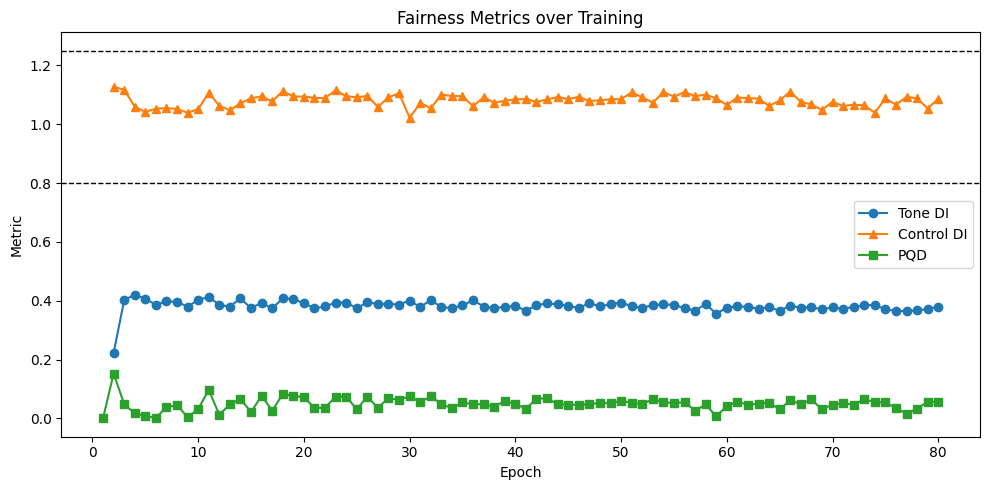

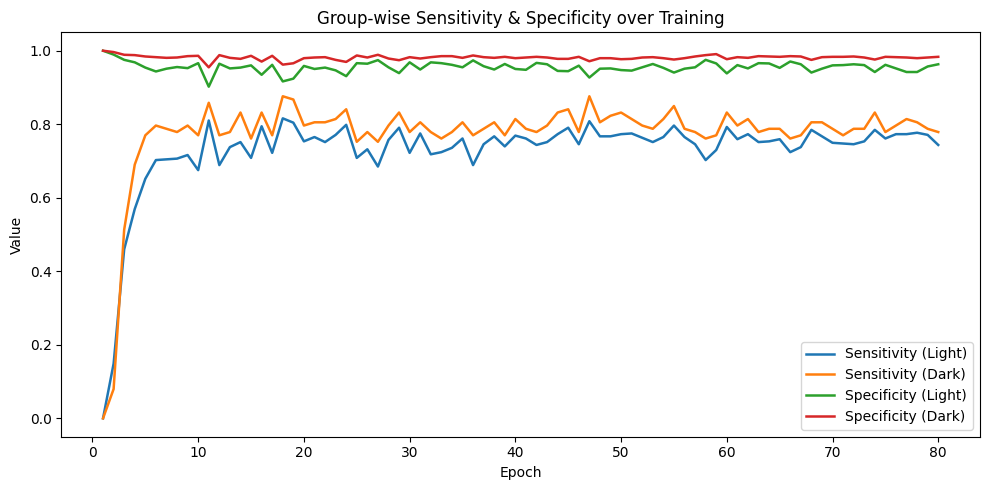

In [5]:
# -------------------
# Plot fairness over epochs
# -------------------
epochs = fair_cb.epochs
H = fair_cb.hist

# TDI, Control DI, PQD
plt.figure(figsize=(10,5))
plt.plot(epochs, H["tdi"], marker='o', lw=1.5, label="Tone DI")
plt.plot(epochs, H["cdi"], marker='^', lw=1.5, label="Control DI")
plt.plot(epochs, H["pqd"], marker='s', lw=1.5, label="PQD")
plt.axhline(0.8, color='k', linestyle='--', lw=1)
plt.axhline(1.25, color='k', linestyle='--', lw=1)
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Fairness Metrics over Training")
plt.legend()
plt.tight_layout()
plt.show()

# Sensitivity/Specificity by group
plt.figure(figsize=(10,5))
plt.plot(epochs, H["sens_light"], lw=1.8, label="Sensitivity (Light)")
plt.plot(epochs, H["sens_dark"],  lw=1.8, label="Sensitivity (Dark)")
plt.plot(epochs, H["spec_light"], lw=1.8, label="Specificity (Light)")
plt.plot(epochs, H["spec_dark"],  lw=1.8, label="Specificity (Dark)")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Group-wise Sensitivity & Specificity over Training")
plt.legend()
plt.tight_layout()
plt.savefig("custom_cnn_imbalance_fairness.png", dpi=300, bbox_inches="tight")
plt.show()


In [3]:
from sklearn.metrics import matthews_corrcoef, roc_curve, auc

for group in ["Light","Dark"]:
    g = merged_df[merged_df["FST_Skintone"] == group]
    if len(g) == 0 or len(np.unique(g["y_true"])) < 2:
        print(f"{group}: not enough data for ROC/MCC.")
        continue
    mcc_g = matthews_corrcoef(g["y_true"], g["y_pred"])
    fpr_g, tpr_g, _ = roc_curve(g["y_true"], g["y_score"])
    auc_g = auc(fpr_g, tpr_g)
    print(f"{group} → MCC: {mcc_g:.4f} | AUC: {auc_g:.4f}")


Light → MCC: 0.7445 | AUC: 0.9409
Dark → MCC: 0.7850 | AUC: 0.9790


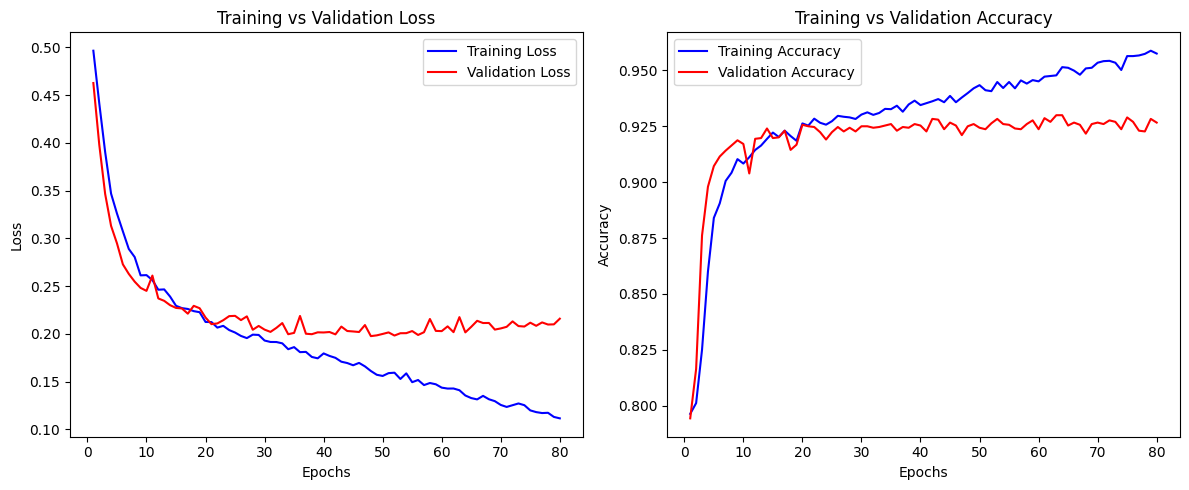

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Find best epoch (lowest val_loss)
best_epoch = np.argmin(val_loss) + 1

plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
#plt.axvline(best_epoch, color='g', linestyle='--', label=f'Early Stopping @ {best_epoch}')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# --- Plot Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
#plt.axvline(best_epoch, color='g', linestyle='--', label=f'Early Stopping @ {best_epoch}')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("custom_cnn_imbalance_loss.png", dpi=300, bbox_inches="tight")
plt.show()
